<a href="https://colab.research.google.com/github/heejae-yoon/Fraud-Detection-in-Card-Transactions/blob/main/transactions_clean_make_variables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook makes variables for the credit card transaction data.
### Nice code improvements made in 2023 by Tim Clarke

In [ ]:
import pandas as pd
import numpy as np
import datetime
import calendar
import timeit
import datetime as dt
import re
from math import exp

!pip install category_encoders
from category_encoders import TargetEncoder

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
start_time = dt.datetime.now()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv('card transactions.csv')
data.shape

(97852, 10)

In [ ]:
data.dropna(how='all', axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])ex
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97852 entries, 0 to 97851
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97852 non-null  int64         
 1   Cardnum            97852 non-null  int64         
 2   Date               97852 non-null  datetime64[ns]
 3   Merchnum           94455 non-null  object        
 4   Merch description  97852 non-null  object        
 5   Merch state        96649 non-null  object        
 6   Merch zip          93149 non-null  float64       
 7   Transtype          97852 non-null  object        
 8   Amount             97852 non-null  float64       
 9   Fraud              97852 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.5+ MB


In [ ]:
data = data[data['Transtype'] == 'P']
data = data[data['Amount'] <= 3000000]
data.shape

(97496, 10)

In [ ]:
data.isna().sum()

,0
Recnum,0
Cardnum,0
Date,0
Merchnum,3220
Merch description,0
Merch state,1028
Merch zip,4347
Transtype,0
Amount,0
Fraud,0


In [ ]:
data_orig = data.copy()

## Clean and impute merchnum

In [ ]:
data['Merchnum'] = data['Merchnum'].replace({'0':np.nan})

In [ ]:
data['Merchnum'].isnull().sum()

3279

In [ ]:
merchdes_merchnum = {}
for index, merchdes in data[data['Merch description'].notnull()][data['Merchnum'].notnull()]['Merch description'].items():
    if pd.isnull(merchdes) == True:
        continue
    elif merchdes not in merchdes_merchnum:
        merchdes_merchnum[merchdes] = data.loc[index, 'Merchnum']

In [ ]:
# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchdes_merchnum))

In [ ]:
data['Merchnum'].isnull().sum()

2115

In [ ]:
# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [ ]:
data['Merchnum'].isnull().sum()

1421

In [ ]:
data.loc[data.Merchnum.isna(), 'Merch description'].unique()[:20]

array(['MONTGOMERY COLLEGE-PHONE', 'COMPRESSOR PARTS & SERVIC',
       'WESTERN SUN             0', 'PACKAGE PLACE  THE',
       'CUBIX CORPORATION', 'SIGNAL GRAPHICS PRINTING',
       'C & M OFFICE EQUIPMENT', "TOMMY'S TRAILERS",
       'Z WORLD/RABBIT SEMICONDUC', 'IMPAC/TRI-COUNTY/FREED',
       'REPROGRPHC TECHNLGIES INC', 'STP SPECIALITY TECH',
       'VANGARD INTERNAITONAL', 'COSTCO WHOLESALE        0',
       'BLACKWELL SCIENCE', 'CDN ISOTOPES INC', 'INTERACTIVE SOFTWARE S',
       'H R WILLIAMS MILL SUPP', 'ELSEVIER SCIENCE BV',
       'COLORADO GARDEN SHOW'], dtype=object)

In [ ]:
# 1403 NULL Merchnums with 508 unique Descriptions
data.loc[data.Merchnum.isna(), 'Merch description'].nunique()

515

### Create new Merchnums using the description field

In [ ]:
# adding new merchnums
# each new unique merchnum will be max(merchnum) + 1
merchnum_create = {}
max_merchnum = pd.to_numeric(data.Merchnum, errors='coerce').max()
for merch_desc in data.loc[data.Merchnum.isna(), 'Merch description'].unique():
  merchnum_create[merch_desc] = str(int(max_merchnum + 1))
  max_merchnum += 1

In [ ]:
# fill in by mapping with Merch description (newly created merchnums)
data['Merchnum'] = data['Merchnum'].fillna(data['Merch description'].map(merchnum_create))

In [ ]:
for i in data.columns:
    print(i, data[i].isnull().sum())

Recnum 0
Cardnum 0
Date 0
Merchnum 0
Merch description 0
Merch state 1028
Merch zip 4347
Transtype 0
Amount 0
Fraud 0


## Clean and impute State

In [ ]:
data['Merch state'].isnull().sum()

1028

In [ ]:
data[data['Merch state'].isnull()].head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
283,284,5142257575,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,320.00,0
293,294,5142124791,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,970.00,0
440,441,5142276099,2010-01-04,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,82.59,0
530,531,5142267793,2010-01-05,unknown,RETAIL DEBIT ADJUSTMENT,NaN,NaN,P,17.59,0
542,543,5142267793,2010-01-05,unknown,RETAIL CREDIT ADJUSTMENT,NaN,NaN,P,19.69,0


In [ ]:
data[(data['Merch state'].isnull()) & (data['Merch zip'].notnull())]['Merch zip'].unique()

array([9.2600e+02, 9.2900e+02, 1.4000e+03, 6.5132e+04, 8.6899e+04,
       2.3080e+04, 6.0528e+04, 9.3400e+02, 9.0200e+02, 7.3800e+02,
       9.0805e+04, 7.6302e+04, 9.0000e+00, 9.1400e+02, 6.0000e+00,
       9.5461e+04, 5.0823e+04, 2.0000e+00, 4.8700e+04, 6.8000e+02,
       1.0000e+00, 6.8100e+02, 6.2300e+02, 7.2600e+02, 9.3600e+02,
       1.2108e+04, 7.9100e+02, 9.0700e+02, 9.2200e+02, 9.2000e+02,
       3.0000e+00, 8.0100e+02, 8.0000e+00, 3.1040e+04, 3.8117e+04,
       4.1160e+04])

In [ ]:
# dict for mapping
zip_state = {}
for index, zip5 in data[data['Merch zip'].notnull()]['Merch zip'].items():
    if zip5 not in zip_state:
        zip_state[zip5] = data.loc[index, 'Merch state']

In [ ]:
zip_state[926.0] = 'PR'
zip_state[929.0] = 'PR'
zip_state[934.0] = 'PR'
zip_state[902.0] = 'PR'
zip_state[738.0] = 'PR'
zip_state[90805.0] = 'CA'
zip_state[76302.0] = 'TX'
zip_state[914.0] = 'PR'
zip_state[95461.0] = 'CA'
zip_state[680.0] = 'PR'
zip_state[623.0] = 'PR'
zip_state[726.0] = 'PR'
zip_state[936.0] = 'PR'
zip_state[12108.0] = 'NY'
zip_state[791.0] = 'PR'
zip_state[907.0] = 'PR'
zip_state[922.0] = 'PR'
zip_state[920.0] = 'PR'
zip_state[801.0] = 'VI'
zip_state[31040.0] = 'GA'
zip_state[41160.0] = 'KY'
zip_state[681.0] = 'PR'

In [ ]:
len(zip_state)

4567

In [ ]:
merchnum_state = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_state :
        merchnum_state [merchnum] = data.loc[index, 'Merch state']

In [ ]:
merchdes_state = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_state :
        merchdes_state [merchdes] = data.loc[index, 'Merch state']

In [ ]:
# fill in by mapping with zip, merchnum and merch description
data['Merch state'].isnull().sum()

1028

In [ ]:
data[data['Merch state'].isnull() & data['Merch zip'].notnull()].head(100)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
3379,3380,5142153880,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2340.00,0
3383,3384,5142154098,2010-01-14,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2387.00,0
3661,3662,5142154098,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2300.00,0
3763,3764,5142153880,2010-01-17,582582822587,DIGITAL TECHNOLOGY CONTRA,NaN,926.0,P,2500.00,0
5090,5091,5142194136,2010-01-24,597597721468,CRISTALIA ACQUISITION COR,NaN,929.0,P,83.00,0
...,...,...,...,...,...,...,...,...,...,...
84236,84237,5142193384,2010-10-26,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,300.00,0
84389,84390,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
84418,84419,5142193384,2010-10-27,600555303209,EMBASSY SUITES PR,NaN,38117.0,P,600.00,0
87369,87370,5142194136,2010-11-10,7007631331,AAFES BUCHANAN MAIN STR,NaN,934.0,P,184.41,0


In [ ]:
data['Merch state'] = data['Merch state'].fillna(data['Merch zip'].map(zip_state))
data['Merch state'].isnull().sum()

954

### Nice! We reduced from 1020 to 947

In [ ]:
data['Merch state'] = data['Merch state'].fillna(data['Merchnum'].map(merchnum_state))
data['Merch state'].isnull().sum()

953

meh...

In [ ]:
data['Merch state'] = data['Merch state'].fillna(data['Merch description'].map(merchdes_state))
data['Merch state'].isnull().sum()

952

double meh...

In [ ]:
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [ ]:
data['Merch state'].isnull().sum()

297

In [ ]:
# change non-US states
# might actually be useful cus fraud could be foreign transactions
# maybe put a 'foreign' tag or just leave them as is

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY",
          'VI', 'PR', np.nan, 'unknown']

for index, state in data['Merch state'].items():
    if state not in states:
        data.loc[index, 'Merch state'] = 'foreign'

In [ ]:
data['Merch state'].fillna('unknown',inplace=True)

In [ ]:
data['Merch state'].isnull().sum()

0

In [ ]:
#Checking for weird stuff, are we sure that all of those digits are gone?

Merch_group = data.groupby(['Merch state'])['Recnum'].count().to_frame().reset_index(drop=False)
pd.set_option('display.max_rows', 300)
Merch_group.head(100)

,Merch state,Recnum
0,AK,164
1,AL,348
2,AR,34
3,AZ,348
4,CA,6896
5,CO,2008
6,CT,964
7,DC,3235
8,DE,71
9,FL,2165


## Clean and impute zip

In [ ]:
data['Merch zip'].isnull().sum()

4347

In [ ]:
merchnum_zip = {}
for index, merchnum in data[data['Merchnum'].notnull()]['Merchnum'].items():
    if merchnum not in merchnum_zip :
        merchnum_zip [merchnum] = data.loc[index, 'Merch zip']

In [ ]:
merchdes_zip = {}
for index, merchdes in data[data['Merch description'].notnull()]['Merch description'].items():
    if merchdes not in merchdes_zip :
        merchdes_zip [merchdes] = data.loc[index, 'Merch zip']

In [ ]:
# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(data['Merchnum'].map(merchnum_zip))
data['Merch zip'] = data['Merch zip'].fillna(data['Merch description'].map(merchdes_zip))

In [ ]:
data['Merch zip'].isnull().sum()

2625

In [ ]:
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [ ]:
data['Merch zip'].isnull().sum()

1940

In [ ]:
temp = data[data['Merch zip'].isna()]
temp.head(10)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
53,54,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
57,58,5142146340,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,23.90,0
58,59,5142260984,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,19.95,0
61,62,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
62,63,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
63,64,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
64,65,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
65,66,5142253356,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,27.41,0
67,68,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0
68,69,5142204384,2010-01-02,5000006000095,IBM INTERNET 01000025,NY,NaN,P,20.15,0


## "Merch zip" impute strategy -
If State is known, but zip is not, will impute the most populated zip code in the state

In [ ]:
# Create a dictionary with each state's two-letter ID and its corresponding most populous zip code. Got this info online.

mostPopZip = {'AL': 35205, 'AK': 99501, 'AZ': 85281, 'AR': 72701, 'CA': 90026, 'CO': 80219, \
              'CT': 6511, 'DE': 19801, 'FL': 33139, 'GA': 30303, 'HI': 96744, 'ID': 83702, \
              'IL': 60647, 'IN': 46201, 'IA': 52404, 'KS': 66102, 'KY': 40203, 'LA': 70119, \
              'ME': 4101, 'MD': 21224, 'MA': 2118, 'MI': 48201, 'MN': 55406, 'MS': 38801, \
              'MO': 63118, 'MT': 59101, 'NE': 68104, 'NV': 89101, 'NH': 3103, 'NJ': 7030, \
              'NM': 87102, 'NY': 11226, 'NC': 28202, 'ND': 58102, 'OH': 44113, 'OK': 74120, \
              'OR': 97214, 'PA': 19107, 'RI': 2903, 'SC': 29203, 'SD': 57103, 'TN': 37203, \
              'TX': 77002, 'UT': 84101, 'VT': 5401, 'VA': 22201, 'WA': 98122, 'WV': 25301, 'WI': 53204, 'WY': 82001}
print(mostPopZip)

{'AL': 35205, 'AK': 99501, 'AZ': 85281, 'AR': 72701, 'CA': 90026, 'CO': 80219, 'CT': 6511, 'DE': 19801, 'FL': 33139, 'GA': 30303, 'HI': 96744, 'ID': 83702, 'IL': 60647, 'IN': 46201, 'IA': 52404, 'KS': 66102, 'KY': 40203, 'LA': 70119, 'ME': 4101, 'MD': 21224, 'MA': 2118, 'MI': 48201, 'MN': 55406, 'MS': 38801, 'MO': 63118, 'MT': 59101, 'NE': 68104, 'NV': 89101, 'NH': 3103, 'NJ': 7030, 'NM': 87102, 'NY': 11226, 'NC': 28202, 'ND': 58102, 'OH': 44113, 'OK': 74120, 'OR': 97214, 'PA': 19107, 'RI': 2903, 'SC': 29203, 'SD': 57103, 'TN': 37203, 'TX': 77002, 'UT': 84101, 'VT': 5401, 'VA': 22201, 'WA': 98122, 'WV': 25301, 'WI': 53204, 'WY': 82001}


In [ ]:
data['Merch zip'] = data['Merch zip'].fillna(data['Merch state'].map(mostPopZip))

In [ ]:
data['Merch zip'].isnull().sum()

531

In [ ]:
data['Merch zip'].fillna('unknown', inplace=True)
data['Merch zip'].isnull().sum()

0

In [ ]:
df = data.copy()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  int64         
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 10.2+ MB


## Let's look more at the strange spike in purchases of $3.62

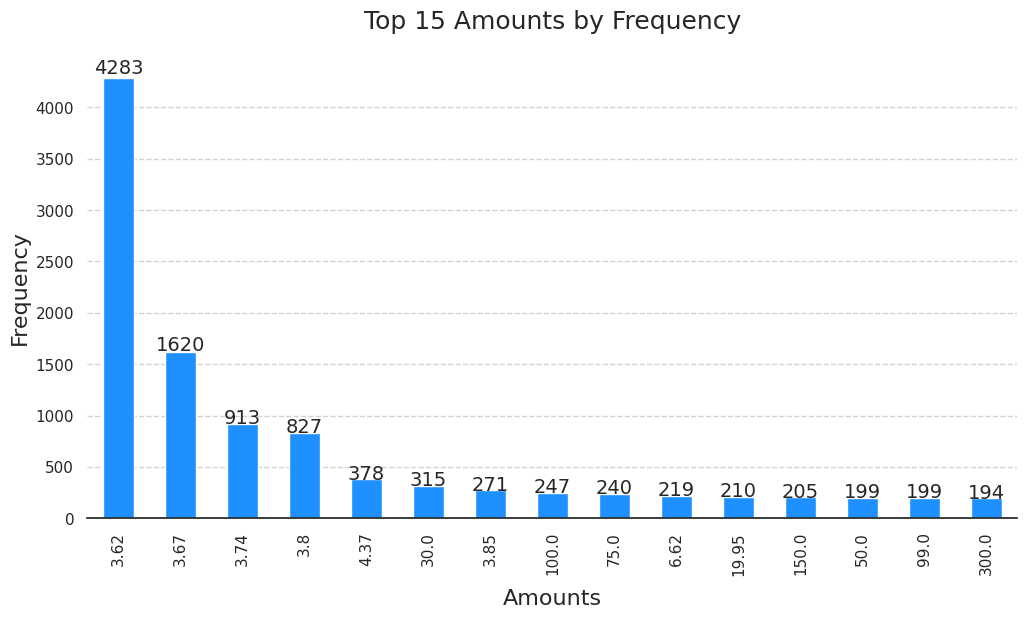

In [ ]:
import matplotlib.dates as mdates
import seaborn as sns

# Set font size and figure size
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (12, 6)

# Use a custom color palette
sns.set(style="white", palette="viridis", rc={"figure.figsize": (12, 6), "lines.linewidth": 2})

# Create the bar plot
ax = data['Amount'].value_counts().head(15).plot(kind='bar', color='dodgerblue')

# Add a title and labels
plt.title('Top 15 Amounts by Frequency', fontsize=18, pad=20)
plt.xlabel('Amounts', fontsize=16, labelpad=10)
plt.ylabel('Frequency', fontsize=16)

# Customize the grid and the spines
sns.despine(left=True)
ax.grid(axis='y', linestyle='--', alpha=0.9)

# Add values on top of the bars
for i, j in enumerate(data['Amount'].value_counts().head(15)):
    ax.text(i, j*1.01, j, ha='center', fontsize=14)

# save plot as a file
# plt.savefig('images/top_amounts_freq.png', dpi=300)

# Display the plot
#plt.yscale('log')
#plt.ylim(bottom = 100)
plt.show()

In [ ]:
data[data['Amount']==3.62].head(20)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0
9,10,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
10,11,5142283088,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.62,0
11,12,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
20,21,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.62,0
21,22,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0
25,26,5142146833,2010-01-01,5509006296254,FEDEX SHP 12/21/09 AB#,TN,38118.0,P,3.62,0


In [ ]:
# This data is so strange and predominate that I need to mark it

data['amount_okay'] = np.where((data['Amount'] >= 3.62) & (data['Amount'] <= 3.80) & (data['Merch description'].str[:5] == "FEDEX"), False, True)

In [ ]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False


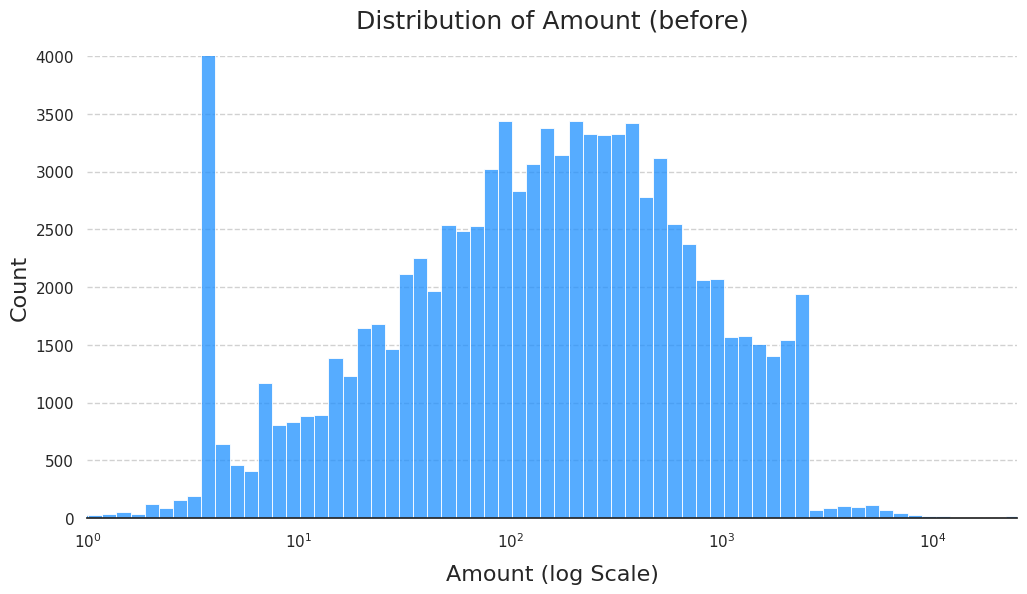

In [ ]:
# set seaborn style and color palette
sns.set_style('white')
sns.set_palette('viridis')

# create histogram plot with seaborn

ax = sns.histplot(data['Amount'], bins=100, color='dodgerblue', log_scale=True)
#ax = sns.histplot(data = data[data['amount_okay']]["Amount"], bins=100, color='dodgerblue', log_scale=True)

# set x-axis limits
ax.set_xlim([1, 25000])

# set y-axis limits
ax.set_ylim([0, 4000])

# Customize the grid and the spines
sns.despine(left=True)
ax.grid(axis='y', linestyle='--', alpha=0.9)

# set plot title and axis labels
plt.title('Distribution of Amount (before)',fontsize=18, pad=20)
plt.xlabel('Amount (log Scale)', fontsize=16, labelpad=10)
plt.ylabel('Count', fontsize=16)

# save plot as a file
# plt.savefig('images/amount_dist.png', dpi=300)

# show plot
plt.show()

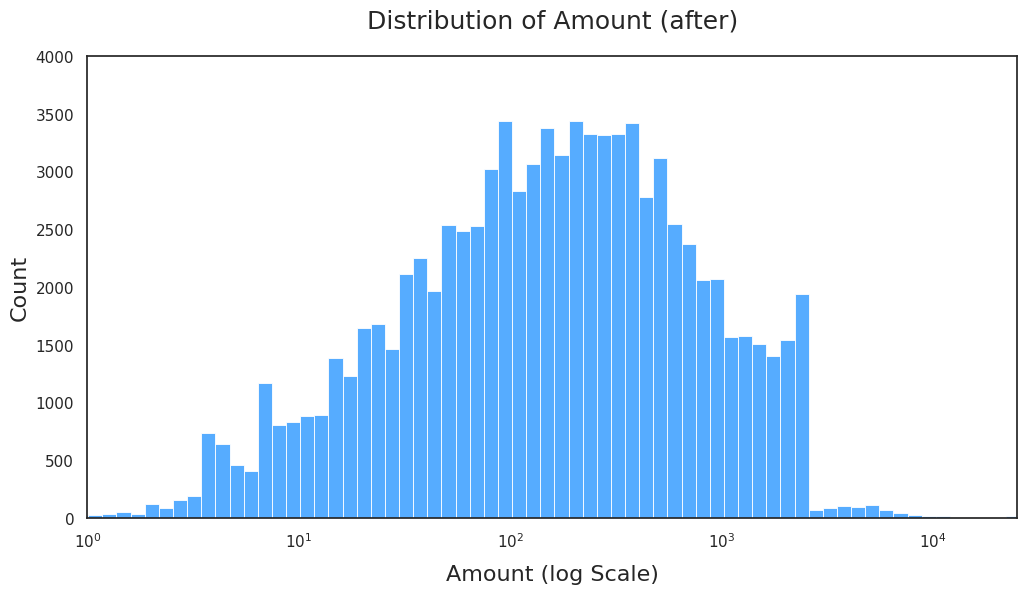

In [ ]:
# create histogram plot with seaborn

ax = sns.histplot(data = data[data['amount_okay']]["Amount"], bins=100, color='dodgerblue', log_scale=True)

# set x-axis limits
ax.set_xlim([1, 25000])

# set y-axis limits
ax.set_ylim([0, 4000])

# set plot title and axis labels
plt.title('Distribution of Amount (after)',fontsize=18, pad=20)
plt.xlabel('Amount (log Scale)', fontsize=16, labelpad=10)
plt.ylabel('Count', fontsize=16)

# save plot as a file
# plt.savefig('images/amount_dist_v2.png', dpi=300)

# show plot
plt.show()

## These cells are the old way I used to do Target Encoding

Before I found the python liobrary 'TargetEncoding' I used to do TE myself, with my own smoothing formula using a logistic curve. I'll leave these cells in here because they make some useful plots, but I'll do the TE later in the notebook.

In [ ]:
## to be safe, check the data type of dates first
df.Date = pd.to_datetime(df.Date)
df.Date.dtypes
## all good

dtype('<M8[ns]')

In [ ]:
## find the day of the week
df['Dow'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])

In [ ]:
## we want to not use the oot for target encoding variables
train_test = df[df.Date < '2010-11-01']

In [ ]:
c = 4; nmid = 20; y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('Dow')['Fraud'].mean()
num = train_test.groupby('Dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1 + np.exp(-(num - nmid)/c))
df['Dow_Risk'] = df.Dow.map(y_dow_smooth)

In [ ]:
y_dow=y_dow.reset_index()
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y_dow['Dow']=pd.Categorical(y_dow['Dow'], categories=cats, ordered=True)
y_dow=y_dow.sort_values('Dow')
y_dow=y_dow.set_index('Dow')
y_dow

,Fraud
Dow,
Monday,0.017613
Tuesday,0.017550
Wednesday,0.025234
Thursday,0.027954
Friday,0.031756
Saturday,0.024280
Sunday,0.014008


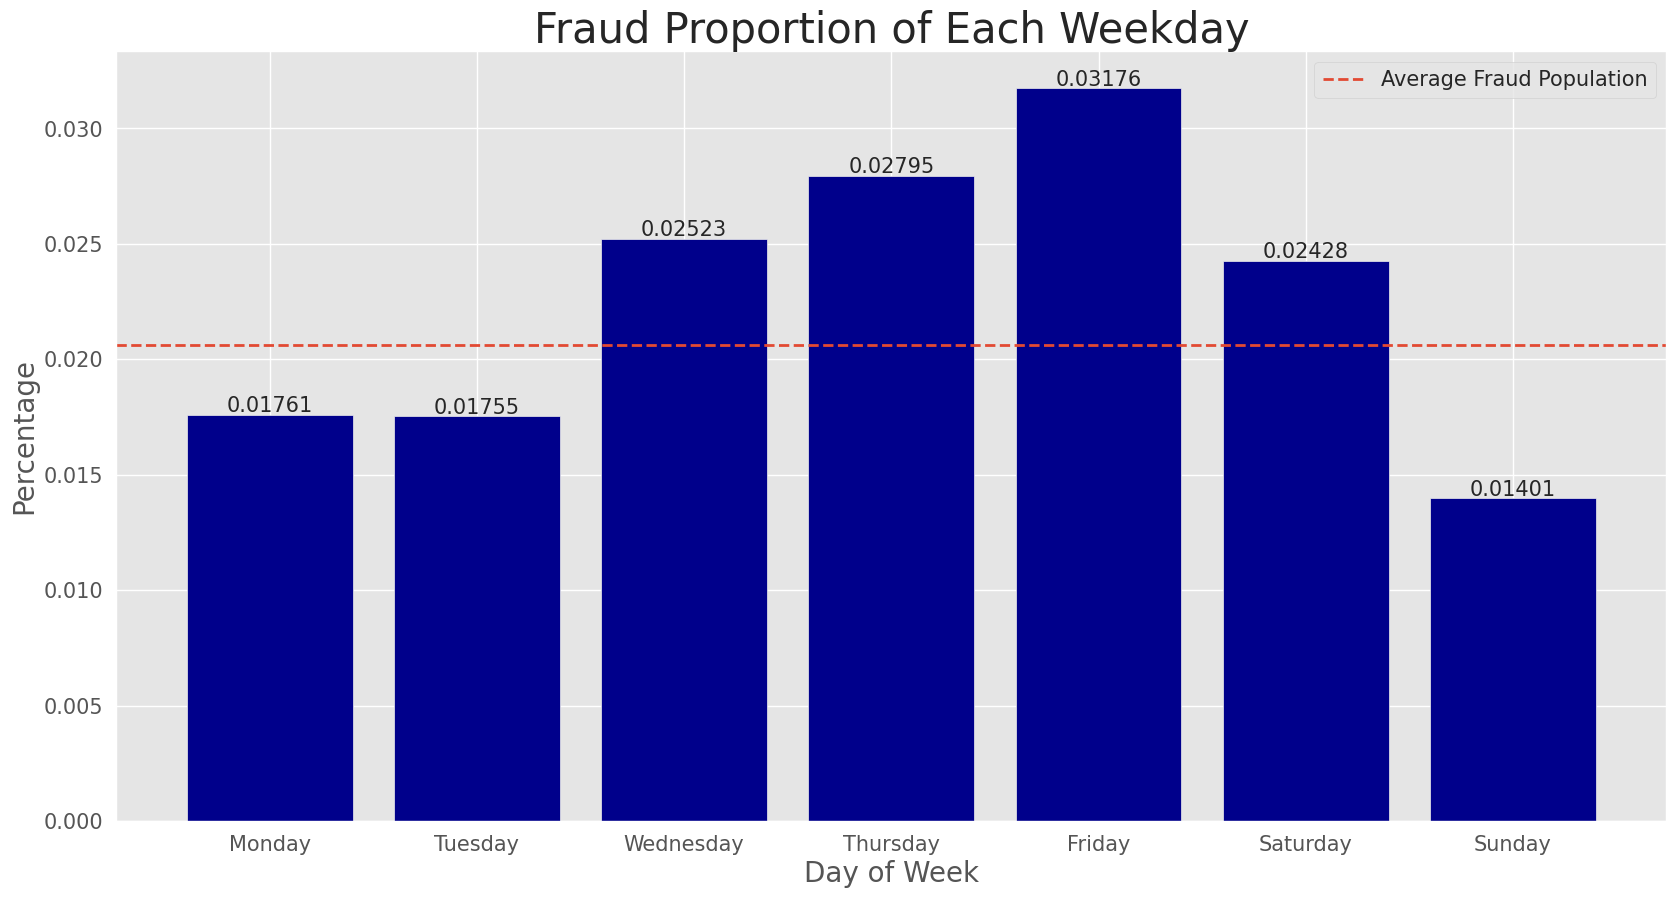

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data = y_dow,
        x = y_dow.index,
        height = 'Fraud',
        color = 'darkblue'
        )
#ax.set_ylim(bottom = 0.013)
ax.axhline(y = y_avg, ls = '--', lw = 2, label="Average Fraud Population")

for i, v in enumerate(y_dow.index):
    ax.text(v,y_dow.loc[v,'Fraud']+0.0001,round(y_dow.loc[v,'Fraud'],5),horizontalalignment='center',fontsize=15)

plt.legend(['Average Fraud Population'], fontsize=15)
plt.xlabel("Day of Week",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Fraud Proportion of Each Weekday", fontsize=30)

plt.show()

In [ ]:
df.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,Dow_Risk
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,Friday,0.031756
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,Friday,0.031756
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,Friday,0.031756


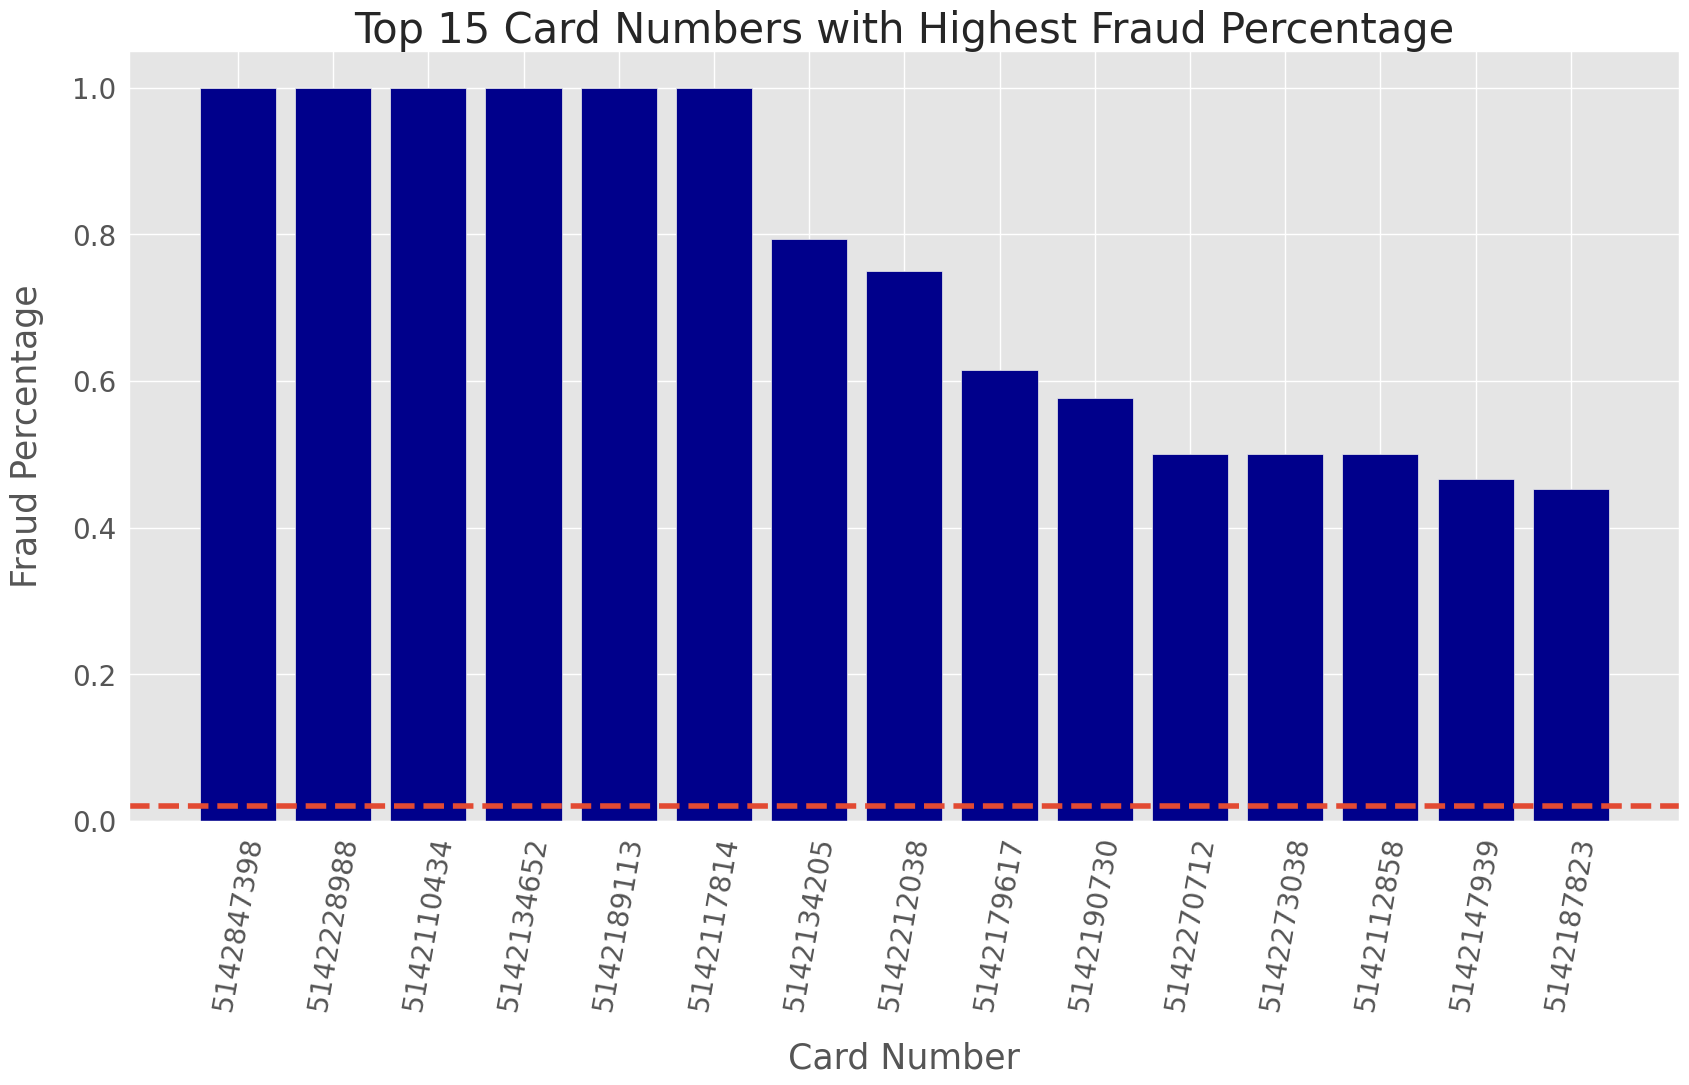

In [ ]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_cardnum = train_test.groupby('Cardnum')['Fraud'].mean()
num = train_test.groupby('Cardnum').size()
y_cardnum_smooth = y_avg + (y_cardnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# df['cardnum_risk'] = df['Cardnum'].map(y_cardnum_smooth)
top15_cardnum = pd.DataFrame(y_cardnum\
                             .sort_values(ascending=False).head(15))
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_cardnum, x=top15_cardnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Card Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Card Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

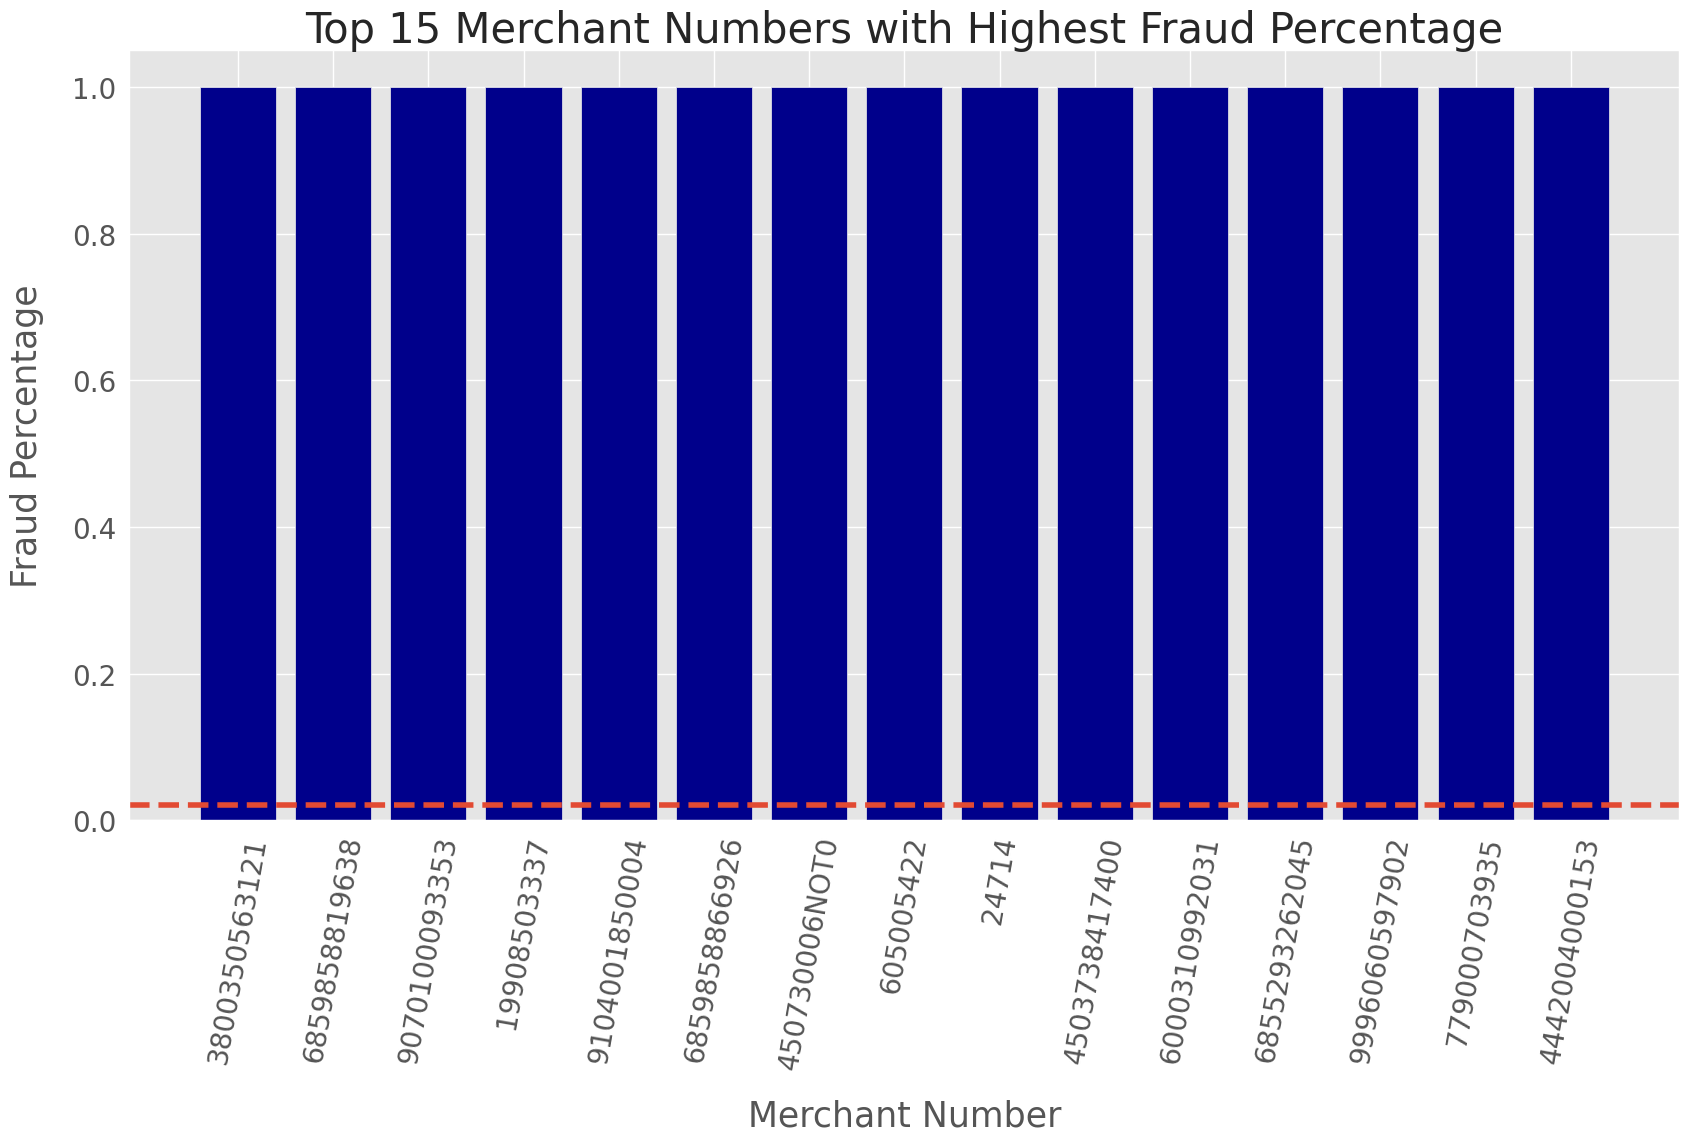

In [ ]:
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_merchnum = train_test.groupby('Merchnum')['Fraud'].mean()
num = train_test.groupby('Merchnum').size()
y_merchnum_smooth = y_avg + (y_merchnum - y_avg)/(1 + np.exp(-(num-nmid)/c))

# comment this out so we don't include this variable because it overfits
# data['merchnum_risk'] = data['Merchnum'].map(y_merchnum_smooth)
top15_merchnum = pd.DataFrame(y_merchnum\
                             .sort_values(ascending=False).head(15))
top15_merchnum.head(20)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20,10))
plt.bar(data=top15_merchnum, x=top15_merchnum.index.astype(str), height='Fraud', color='darkblue')
plt.title('Top 15 Merchant Numbers with Highest Fraud Percentage', fontsize=30)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Merchant Number',fontsize=25, labelpad=20)
plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
plt.xticks(rotation = 80)

ax.axhline(y=y_avg, lw = 4, ls='--')

plt.show()

In [ ]:
df['Cardnum'] = df['Cardnum'].apply(str)
df['Merchnum'] = df['Merchnum'].apply(str)
df['Merch zip'] = df['Merch zip'].apply(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  object        
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  Dow                97496 non-null  object        
 11  Dow_Risk           97496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [ ]:
### add leading 0 to zips
### note: there are some zips that are state abbrv. as we imputed them ealier, so pandas read the column as str

def leading_0(x):

    if '.0' in x:
        x = x[:-2]
        if len(x) == 5:
            return x
        else:
            return '0'*(5-len(x)) + x
    else:
        return '0'*(5-len(x)) + x

df['Merch zip'] = df['Merch zip'].apply(leading_0)

In [ ]:
### delete white spaces in merch description
df['Merch description'] = df['Merch description'].str.replace(r'\s', '')

### Create entities for grouping/linking variables

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97496 entries, 0 to 97851
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             97496 non-null  int64         
 1   Cardnum            97496 non-null  object        
 2   Date               97496 non-null  datetime64[ns]
 3   Merchnum           97496 non-null  object        
 4   Merch description  97496 non-null  object        
 5   Merch state        97496 non-null  object        
 6   Merch zip          97496 non-null  object        
 7   Transtype          97496 non-null  object        
 8   Amount             97496 non-null  float64       
 9   Fraud              97496 non-null  int64         
 10  Dow                97496 non-null  object        
 11  Dow_Risk           97496 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 11.7+ MB


In [ ]:
df['card_merch'] = df['Cardnum'] + df['Merchnum']
df['card_zip'] = df['Cardnum'] + df['Merch zip']
df['card_state'] = df['Cardnum'] + df['Merch state']
df['merch_zip'] = df['Merchnum'] + df['Merch zip']
df['merch_state'] = df['Merchnum'] + df['Merch state']
df['state_des'] = df['Merch state'] + df['Merch description']
df['Card_Merchdesc'] = df['Cardnum'] + df['Merch description']
df['Card_dow'] = df['Cardnum'] + df['Dow']
df['Merchnum_desc'] = df['Merchnum'] + df['Merch description']
df['Merchnum_dow'] = df['Merchnum'] + df['Dow']
df['Merchdesc_dow'] = df['Merch description'] + df['Dow']
df['Card_Merchnum_desc'] = df['Cardnum'] + df['Merchnum'] + df['Merch description']
df['Card_Merchnum_Zip'] = df['Cardnum'] + df['Merchnum'] + df['Merch zip']
df['Card_Merchdesc_Zip'] = df['Cardnum'] + df['Merch description'] + df['Merch zip']
df['Merchnum_desc_State'] = df['Merchnum'] + df['Merch description'] + df['Merch state']
df['Merchnum_desc_Zip'] = df['Merchnum'] + df['Merch description'] + df['Merch zip']
df['merchnum_zip'] = df.Merchnum + df['Merch zip']
df['Merchdesc_State'] = df['Merch description'] + df['Merch state']
df['Merchdesc_Zip'] = df['Merch description'] + df['Merch zip']
df['Card_Merchnum_State'] = df['Cardnum'] + df['Merchnum'] + df['Merch state']
df['Card_Merchdesc_State'] = df['Cardnum'] + df['Merch description'] + df['Merch state']

# you can try adding more entities
# I think the zip3 entities take a lot of time, same with state_zip

# df['zip3'] = df['Merch zip'].str[:3]
# df['card_zip3'] = df.Cardnum + df['zip3']
# df['state_zip'] = df['Merch state'] + df['Merch zip']
# df['merchnum_zip3'] = df.Merchnum + df['zip3']

In [ ]:
df.dtypes

,0
Recnum,int64
Cardnum,object
Date,datetime64[ns]
Merchnum,object
Merch description,object
Merch state,object
Merch zip,object
Transtype,object
Amount,float64
Fraud,int64


In [ ]:
df.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'card_merch', 'card_zip', 'card_state', 'merch_zip',
       'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow',
       'Merchnum_desc', 'Merchnum_dow', 'Merchdesc_dow', 'Card_Merchnum_desc',
       'Card_Merchnum_Zip', 'Card_Merchdesc_Zip', 'Merchnum_desc_State',
       'Merchnum_desc_Zip', 'merchnum_zip', 'Merchdesc_State', 'Merchdesc_Zip',
       'Card_Merchnum_State', 'Card_Merchdesc_State'],
      dtype='object')

In [ ]:
entities = list(df.iloc[:, np.r_[1, 3, 12:len(df.columns)]].columns)

In [ ]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
# if the number in any entity group is really low it won't be a good linking entity
ent_2_remove = []
for ent in entities:
    num = len(df.groupby(ent))
    print(ent, num)
    if num <= 10:
        print('remove',ent)
        ent_2_remove.append(ent)
    else:
        print('ok',ent)

ent_2_remove

Cardnum 1643
ok Cardnum
Merchnum 13605
ok Merchnum
card_merch 40220
ok card_merch
card_zip 33829
ok card_zip
card_state 15971
ok card_state
merch_zip 13839
ok merch_zip
merch_state 13672
ok merch_state
state_des 13251
ok state_des
Card_Merchdesc 43183
ok Card_Merchdesc
Card_dow 9182
ok Card_dow
Merchnum_desc 14592
ok Merchnum_desc
Merchnum_dow 27816
ok Merchnum_dow
Merchdesc_dow 27775
ok Merchdesc_dow
Card_Merchnum_desc 45353
ok Card_Merchnum_desc
Card_Merchnum_Zip 40419
ok Card_Merchnum_Zip
Card_Merchdesc_Zip 43514
ok Card_Merchdesc_Zip
Merchnum_desc_State 14634
ok Merchnum_desc_State
Merchnum_desc_Zip 14790
ok Merchnum_desc_Zip
merchnum_zip 13839
ok merchnum_zip
Merchdesc_State 13251
ok Merchdesc_State
Merchdesc_Zip 13530
ok Merchdesc_Zip
Card_Merchnum_State 40250
ok Card_Merchnum_State
Card_Merchdesc_State 43278
ok Card_Merchdesc_State


[]

In [ ]:
df.drop(columns=ent_2_remove,inplace=True)
entities = [i for i in entities if i not in ent_2_remove]
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
icols = 0
for col in data.columns:
    print(icols, col)
    icols = icols+1

0 Recnum
1 Cardnum
2 Date
3 Merchnum
4 Merch description
5 Merch state
6 Merch zip
7 Transtype
8 Amount
9 Fraud
10 amount_okay


In [ ]:
# The dataframe 'final' will be our variables
df.Date = pd.to_datetime(df.Date)
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.Date
df1['check_record'] = df1.Recnum

## Identify categorical fields for Target Encoding

In [ ]:
df.nunique()

,0
Recnum,97496
Cardnum,1643
Date,365
Merchnum,13605
Merch description,12973
Merch state,55
Merch zip,4579
Transtype,1
Amount,35310
Fraud,2


In [ ]:
# For TE we want the cardinality to be not too high.
# We're basically giving a "black mark" to any category value that has had high fraud in the past.

col_TE = ['Merch state','Merch zip','Dow']

In [ ]:
# Now make the TE variables
TE = TargetEncoder()
data_cat_TE = df[col_TE]
data_cat_TE.head()

,Merch state,Merch zip,Dow
0,TN,38118,Friday
1,MA,01803,Friday
2,MD,20706,Friday
3,TN,38118,Friday
4,TN,38118,Friday


In [ ]:
data_cat_TE_Xtrntst = train_test[col_TE]
TE.fit(data_cat_TE_Xtrntst,train_test['Fraud'])
temp1 = TE.transform(data_cat_TE)
temp1.shape

(97496, 3)

In [ ]:
temp1.head()

,Merch state,Merch zip,Dow
0,0.017176,0.020604,0.031756
1,0.015752,0.020604,0.031756
2,0.028553,0.020604,0.031756
3,0.017176,0.020604,0.031756
4,0.017176,0.020604,0.031756


In [ ]:
temp1.isna().sum()

,0
Merch state,0
Merch zip,0
Dow,0


In [ ]:
for col in temp1.columns:
      temp1.rename(columns={col:col + '_TE'}, inplace=True)

temp1.head()

,Merch state_TE,Merch zip_TE,Dow_TE
0,0.017176,0.020604,0.031756
1,0.015752,0.020604,0.031756
2,0.028553,0.020604,0.031756
3,0.017176,0.020604,0.031756
4,0.017176,0.020604,0.031756


In [ ]:
print('before the TE variables:',final.shape)
final = pd.concat([final,temp1], axis = 1)
print('after the TE variables:',final.shape)

before the TE variables: (97496, 33)
after the TE variables: (97496, 36)


In [ ]:
temp2 = pd.concat([data_cat_TE,temp1], axis = 1)
print(temp2.shape)
temp2.head()

(97496, 6)


,Merch state,Merch zip,Dow,Merch state_TE,Merch zip_TE,Dow_TE
0,TN,38118,Friday,0.017176,0.020604,0.031756
1,MA,01803,Friday,0.015752,0.020604,0.031756
2,MD,20706,Friday,0.028553,0.020604,0.031756
3,TN,38118,Friday,0.017176,0.020604,0.031756
4,TN,38118,Friday,0.017176,0.020604,0.031756


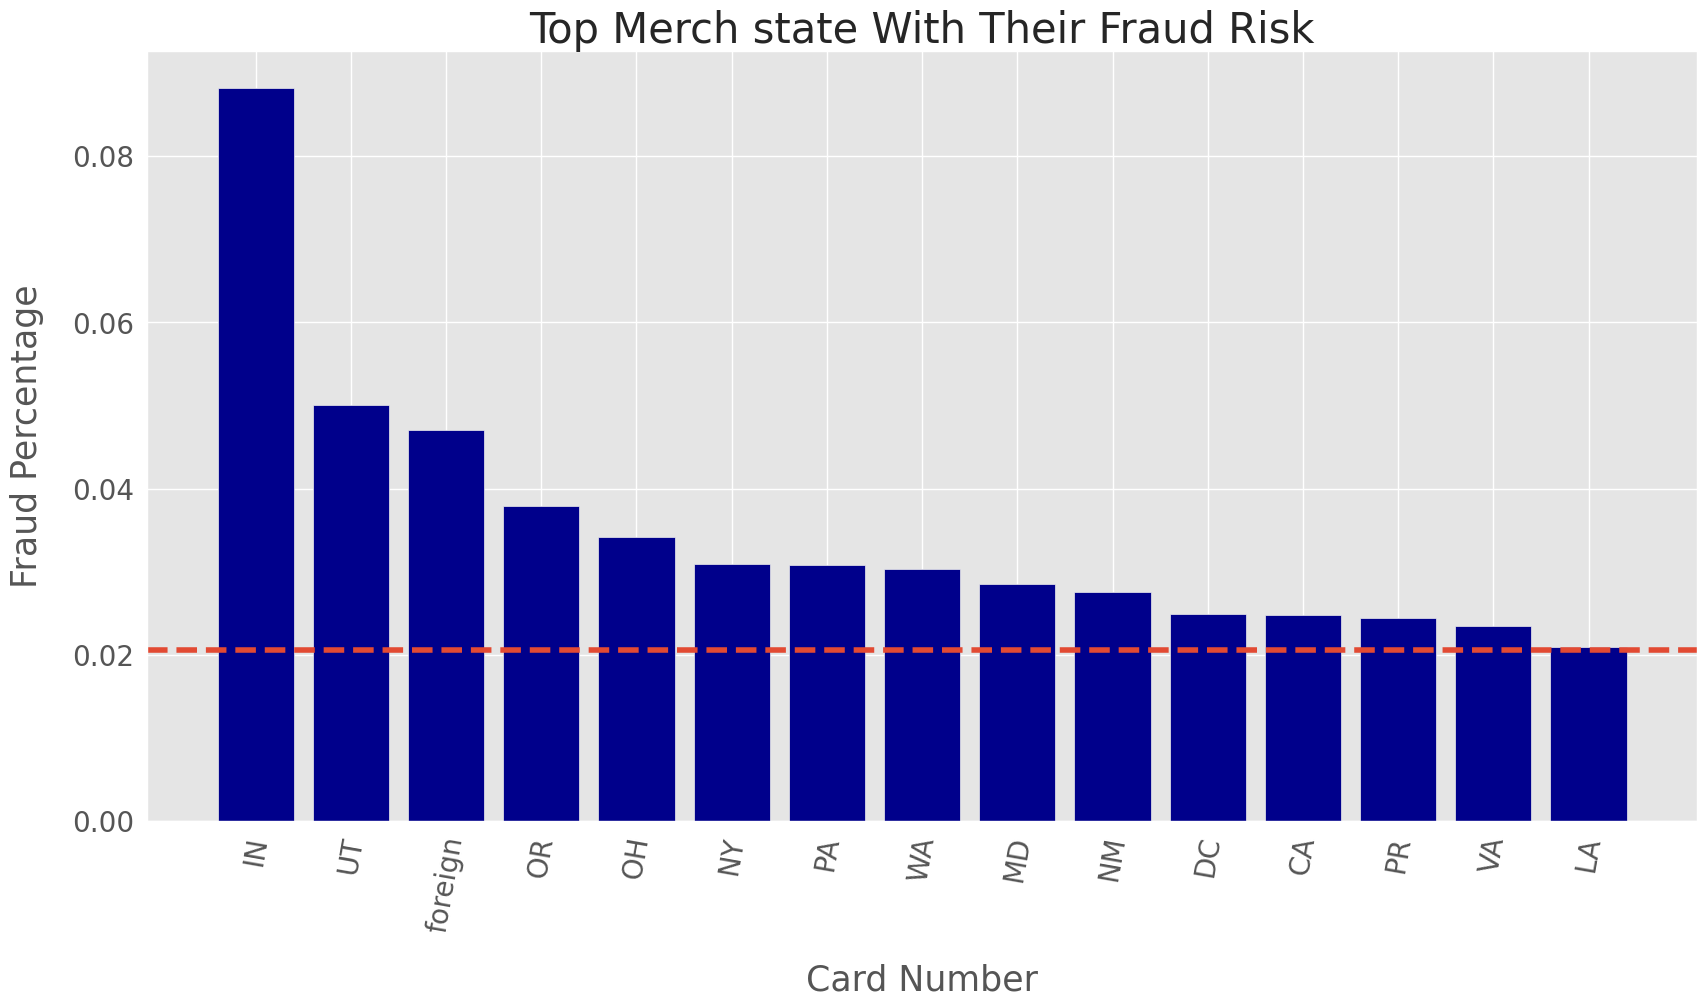

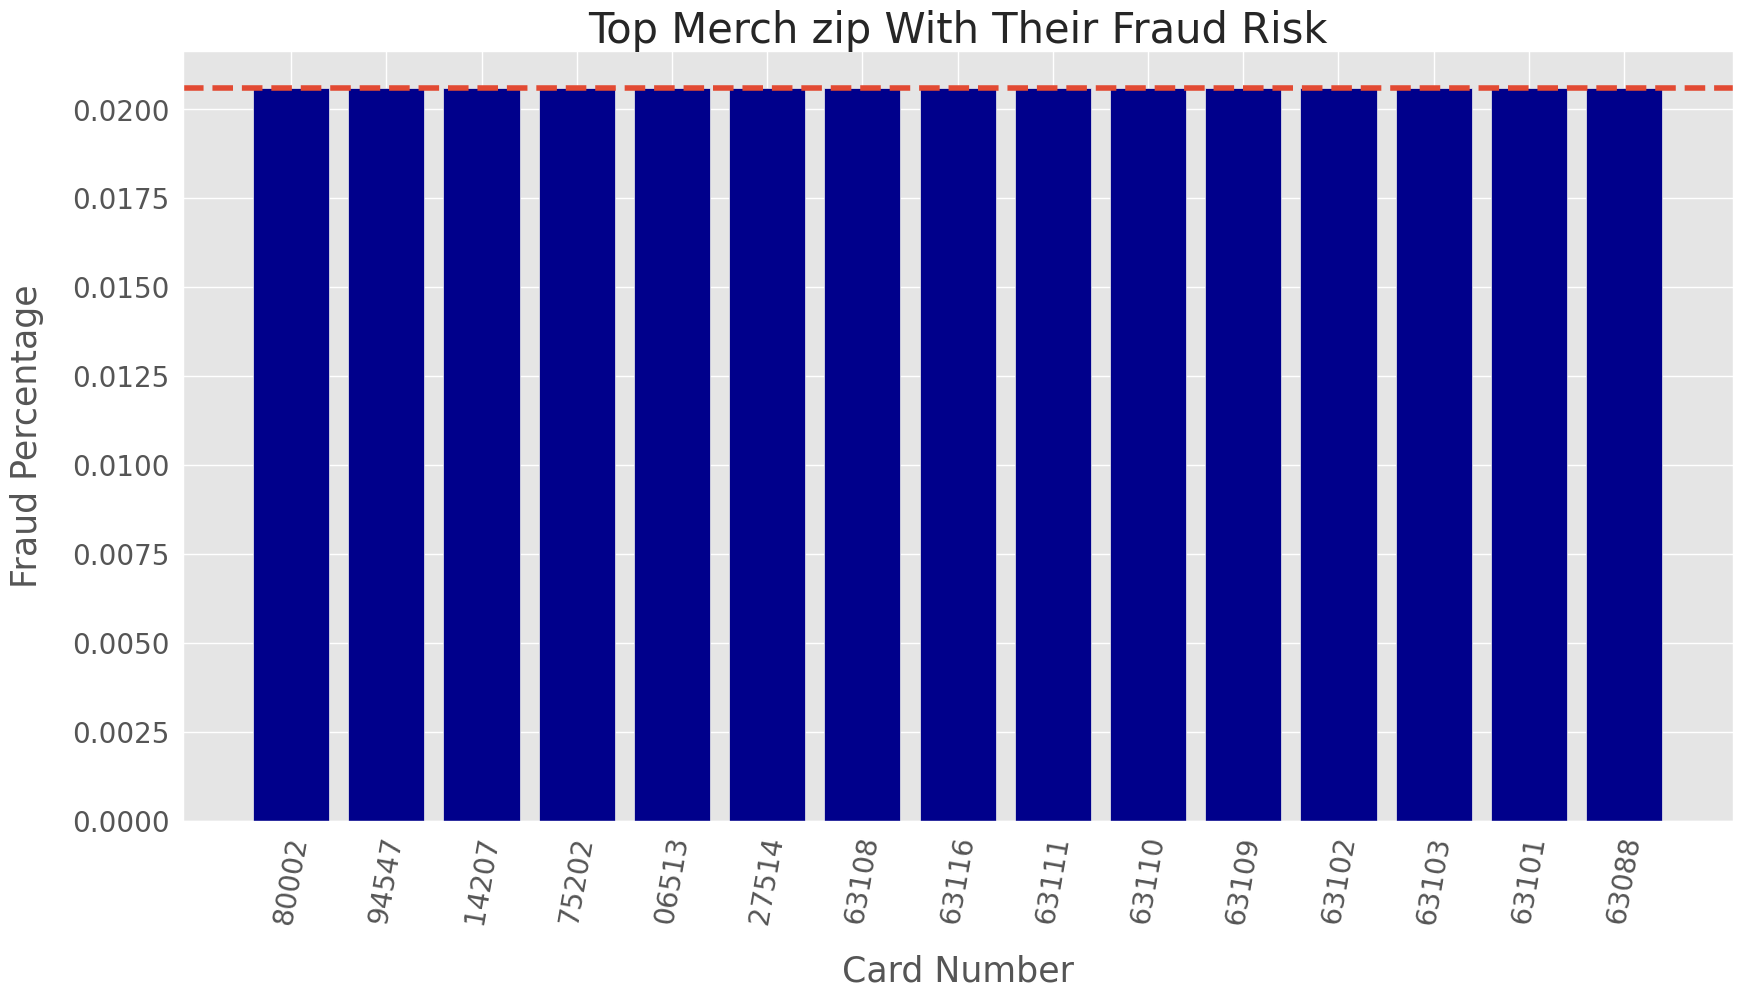

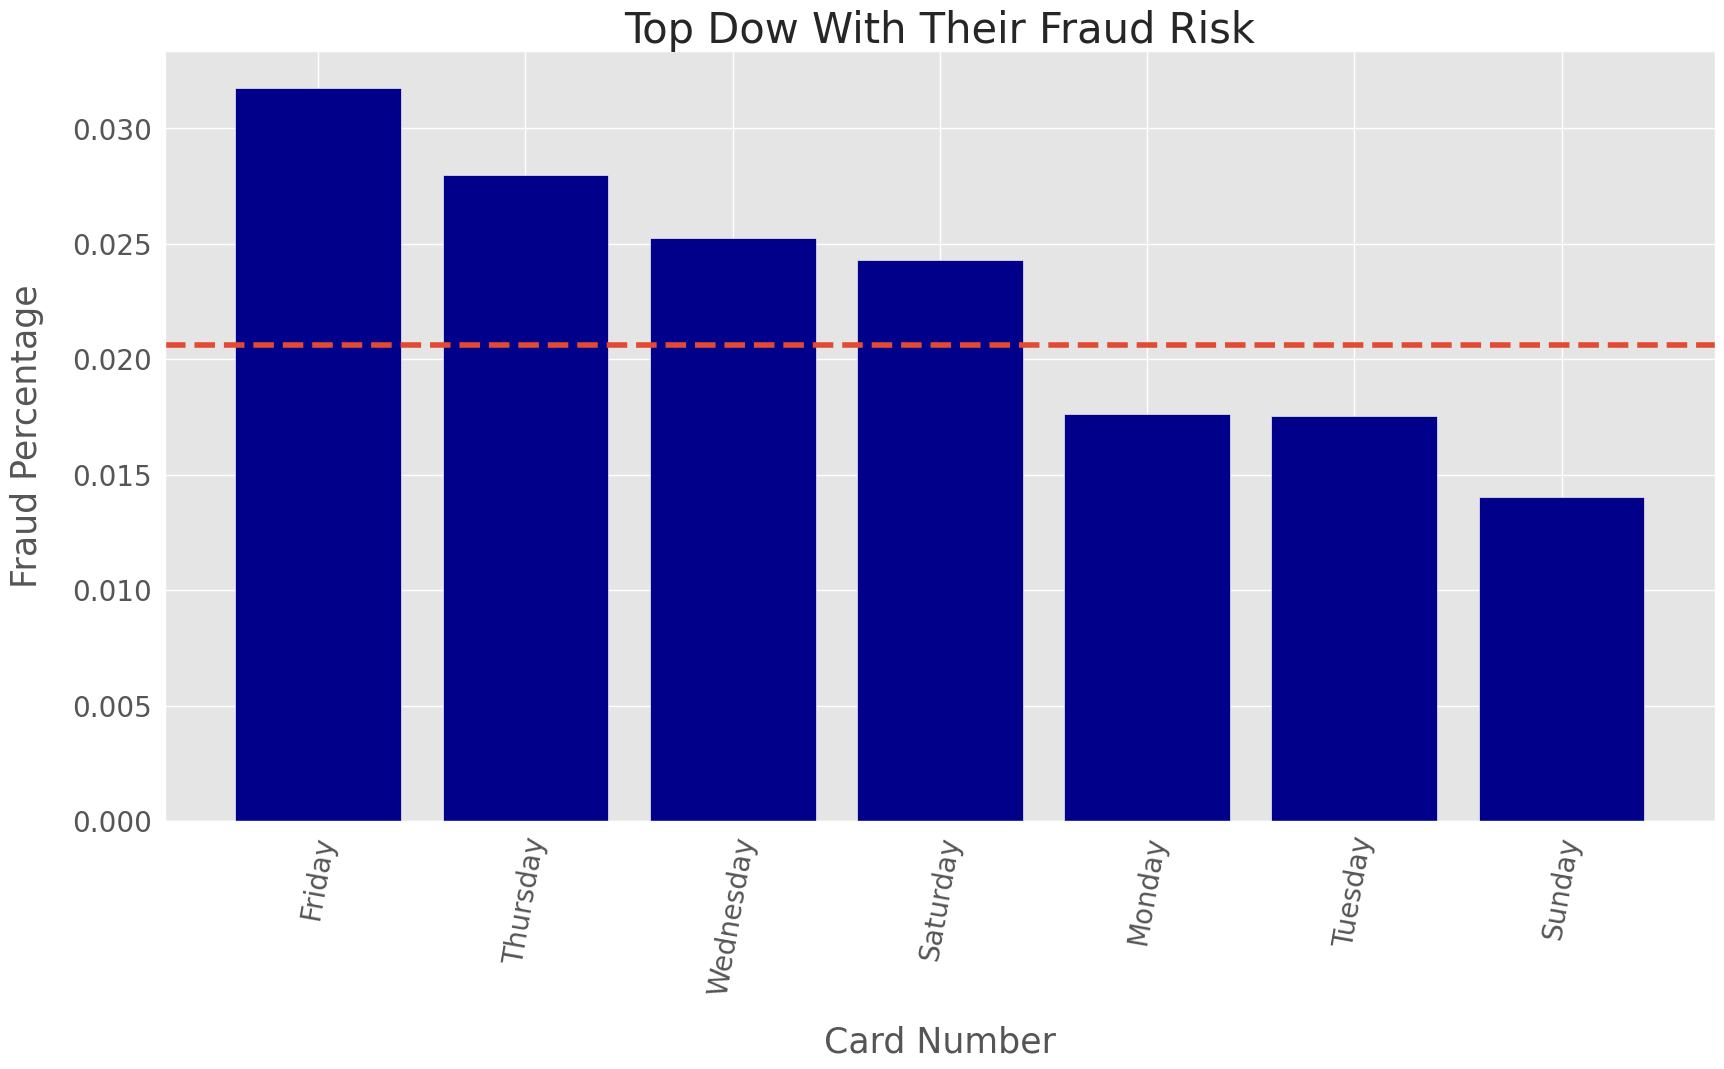

In [ ]:
for col in col_TE:
    temp3 = temp2.groupby(col)[col+'_TE'].mean()
    toplist = pd.DataFrame(temp3.sort_values(ascending=False).head(15))
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(20,10))
    plt.bar(data=toplist, x=toplist.index.astype(str), height=col+'_TE', color='darkblue')
    plt.title('Top '+col+' With Their Fraud Risk', fontsize=30)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Card Number',fontsize=25, labelpad=20)
    plt.ylabel('Fraud Percentage',fontsize=25, labelpad=20)
    plt.xticks(rotation = 80)

    ax.axhline(y=y_avg, lw = 4, ls='--')

    plt.show()

## Make the Benford's law top 40 tables and variables

In [ ]:
# another way to get the first digit
bf = data.copy()
bf['amount_100'] = (bf['Amount'] * 100).astype(str)
bf['first_digit'] = bf['amount_100'].str[0]
bf['first_digit'].value_counts()

,count
first_digit,
1,26940
3,18816
2,16368
4,8379
5,7027
6,6099
7,5087
8,4594
9,4186


In [ ]:
# dropfedex = bf[bf['Merch description'].str.contains('FEDEX')]
dropfedex = bf[bf['amount_okay']==False]
dropfedex.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
5,6,5142149874,2010-01-01,5509006296254,FEDEX SHP 12/22/09 AB#,TN,38118.0,P,3.67,0,False,367.0,3
6,7,5142189277,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3


In [ ]:
droplist = dropfedex.index.tolist()
droplist[:10]

[0, 3, 4, 5, 6, 9, 10, 11, 15, 16]

In [ ]:
droplist[-10:]

[97231, 97238, 97307, 97333, 97345, 97391, 97418, 97496, 97525, 97558]

In [ ]:
len(droplist)

7592

In [ ]:
bf.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True,3142.0,3
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True,17849.0,1
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118.0,P,3.62,0,False,362.0,3


In [ ]:
bf.shape

(97496, 13)

In [ ]:
bf1 = bf.drop(droplist)
bf1.shape

(89904, 13)

In [ ]:
# datefilter = datetime.datetime(2010,11,1)
# bf1 = bf1[bf1['Date'] < datefilter]
# bf1.shape

In [ ]:
bf1['bin']= bf1['first_digit'].apply(lambda x: "low" if x == "1" else ("low" if x == "2" else "high"))
bf1.head(5)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,amount_okay,amount_100,first_digit,bin
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,1803.0,P,31.42,0,True,3142.0,3,high
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706.0,P,178.49,0,True,17849.0,1,low
7,8,5142191182,2010-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429.0,P,230.32,0,True,23032.0,2,low
8,9,5142258629,2010-01-01,602608969534,FISHER SCI ATL,GA,30091.0,P,62.11,0,True,6211.0,6,high
12,13,5142146134,2010-01-01,5509006296254,FEDEX SHP 12/21/09 AB#,TN,38118.0,P,3.85,0,True,385.0,3,high


In [ ]:
bf1['first_digit'].value_counts()

,count
first_digit,
1,26940
2,16368
3,11224
4,8379
5,7027
6,6099
7,5087
8,4594
9,4186


In [ ]:
# calculating n_low and n_high
card_bf =  bf1.groupby(['Cardnum','bin']).agg({'bin': ['count']}).reset_index()
card_bf.columns=['Cardnum', 'bin', 'count']
card_bf

,Cardnum,bin,count
0,5142110002,low,1
1,5142110081,high,4
2,5142110313,high,1
3,5142110313,low,2
4,5142110402,high,8
...,...,...,...
3132,5142310598,low,2
3133,5142310768,high,2
3134,5142310768,low,2
3135,5142847398,high,35


In [ ]:
card_bf =  card_bf.pivot_table(index='Cardnum',columns='bin',values='count',aggfunc='sum').reset_index()
card_bf.columns=['Cardnum', 'n_high', 'n_low']
card_bf

,Cardnum,n_high,n_low
0,5142110002,NaN,1.0
1,5142110081,4.0,NaN
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,NaN,1.0
...,...,...,...
1637,5142310397,1.0,NaN
1638,5142310525,3.0,1.0
1639,5142310598,NaN,2.0
1640,5142310768,2.0,2.0


In [ ]:
# if either n_low or n_high is zero, set it to 1
card_bf = card_bf.fillna(1)
card_bf

,Cardnum,n_high,n_low
0,5142110002,1.0,1.0
1,5142110081,4.0,1.0
2,5142110313,1.0,2.0
3,5142110402,8.0,3.0
4,5142110434,1.0,1.0
...,...,...,...
1637,5142310397,1.0,1.0
1638,5142310525,3.0,1.0
1639,5142310598,1.0,2.0
1640,5142310768,2.0,2.0


In [ ]:
# calclating R, 1/R, U, n, t U_smoothed
c=3
n_mid=15
card_bf['R'] = (1.096 * card_bf['n_low']/card_bf['n_high'])
card_bf['1/R'] = (1/card_bf['R'])
card_bf['U'] = list(map(lambda x, y : max(x,y),card_bf['R'],card_bf['1/R']))
card_bf['n'] = card_bf['n_high'] + card_bf['n_low']
card_bf['t'] = ((card_bf['n']-n_mid)/c)
card_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),card_bf['U'],card_bf['t']))

In [ ]:
top40_card_bf = card_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_card_bf.head(40)

,Cardnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,5142253356,5.0,61.0,13.371200,0.074788,13.371200,66.0,17.000000,13.371199
1,5142299634,65.0,7.0,0.118031,8.472367,8.472367,72.0,19.000000,8.472367
2,5142197563,134.0,16.0,0.130866,7.641423,7.641423,150.0,45.000000,7.641423
3,5142194617,33.0,5.0,0.166061,6.021898,6.021898,38.0,7.666667,6.019548
4,5142297710,135.0,22.0,0.178607,5.598872,5.598872,157.0,47.333333,5.598872
5,5142288241,13.0,1.0,0.084308,11.861314,11.861314,14.0,-0.333333,5.533836
6,5142239140,3.0,16.0,5.845333,0.171077,5.845333,19.0,1.333333,4.834555
7,5142144931,30.0,6.0,0.219200,4.562044,4.562044,36.0,7.000000,4.558799
8,5142148452,450.0,99.0,0.241120,4.147313,4.147313,549.0,178.000000,4.147313
9,5142192606,2.0,13.0,7.124000,0.140371,7.124000,15.0,0.000000,4.062000


In [ ]:
# calculating n_low and n_high
merch_bf =  bf1.groupby(['Merchnum','bin']).agg({'bin': ['count']}).reset_index()
merch_bf.columns=['Merchnum', 'bin', 'count']
merch_bf =  merch_bf.pivot_table(index='Merchnum',columns='bin',values='count',aggfunc='sum').reset_index()
merch_bf.columns=['Merchnum', 'n_high', 'n_low']
merch_bf.head()

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,NaN
1,004740006ABC6,NaN,1.0
2,005590006PNB6,1.0,NaN
3,014430619 14,NaN,1.0
4,014938913 51,1.0,NaN


In [ ]:
# if either n_low or n_high is zero, set it to 1
merch_bf = merch_bf.fillna(1)
merch_bf

,Merchnum,n_high,n_low
0,003100006NOT6,1.0,1.0
1,004740006ABC6,1.0,1.0
2,005590006PNB6,1.0,1.0
3,014430619 14,1.0,1.0
4,014938913 51,1.0,1.0
...,...,...,...
13600,DU49038320006,1.0,1.0
13601,JCPENNE9 CO,2.0,1.0
13602,PENNE9 CO #05,1.0,1.0
13603,PENNE9 CO #68,1.0,1.0


In [ ]:
# calclating R, 1/R, U, n, t U_smoothed
merch_bf['R'] = (1.096 * merch_bf['n_low']/merch_bf['n_high'])
merch_bf['1/R'] = (1/merch_bf['R'])
merch_bf['U'] = list(map(lambda x, y : max(x,y),merch_bf['R'],merch_bf['1/R']))
merch_bf['n'] = merch_bf['n_high'] + merch_bf['n_low']
merch_bf['t'] = ((merch_bf['n']-n_mid)/c)
merch_bf['U_smoothed']= list(map(lambda x, y : (1 + (x-1)/(1+exp(-y))),merch_bf['U'],merch_bf['t']))

In [ ]:
top40_merch_bf = merch_bf.sort_values(['U_smoothed'], ascending = False).head(40).reset_index(drop = True)
top40_merch_bf.head(40)

,Merchnum,n_high,n_low,R,1/R,U,n,t,U_smoothed
0,991808369338,184.0,1.0,0.005957,167.883212,167.883212,185.0,56.666667,167.883212
1,308904389335,53.0,1.0,0.020679,48.357664,48.357664,54.0,13.000000,48.357557
2,3523000628102,1.0,34.0,37.264000,0.026836,37.264000,35.0,6.666667,37.217908
3,55158027,1.0,27.0,29.592000,0.033793,29.592000,28.0,4.333333,29.221627
4,8916500620062,31.0,1.0,0.035355,28.284672,28.284672,32.0,5.666667,28.190609
5,3910694900001,1.0,25.0,27.400000,0.036496,27.400000,26.0,3.666667,26.741995
6,881145544,1.0,24.0,26.304000,0.038017,26.304000,25.0,3.333333,25.432399
7,6844000608436,1.0,23.0,25.208000,0.039670,25.208000,24.0,3.000000,24.059914
8,8078200641472,3.0,59.0,21.554667,0.046394,21.554667,62.0,15.666667,21.554663
9,92891948003,24.0,1.0,0.045667,21.897810,21.897810,25.0,3.333333,21.177981


In [ ]:
# Here are the tables for the Benford's law. They would be useful for a forensic analysis
top40_card_bf.to_csv('Benford top cards.csv')
top40_merch_bf.to_csv('Benford top merchs.csv')

In [ ]:
card_bf['Cardnum'] = card_bf['Cardnum'].apply(str)
merch_bf['Merchnum'] = merch_bf['Merchnum'].apply(str)
card_bf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cardnum     1642 non-null   object 
 1   n_high      1642 non-null   float64
 2   n_low       1642 non-null   float64
 3   R           1642 non-null   float64
 4   1/R         1642 non-null   float64
 5   U           1642 non-null   float64
 6   n           1642 non-null   float64
 7   t           1642 non-null   float64
 8   U_smoothed  1642 non-null   float64
dtypes: float64(8), object(1)
memory usage: 115.6+ KB


In [ ]:
card_bf.set_index('Cardnum',inplace=True)

In [ ]:
card_Ustar = pd.DataFrame(card_bf['U_smoothed'])
card_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Cardnum,
5142253356,13.371199
5142299634,8.472367
5142197563,7.641423
5142194617,6.019548
5142297710,5.598872
5142288241,5.533836
5142239140,4.834555
5142144931,4.558799
5142148452,4.147313


In [ ]:
merch_bf.set_index('Merchnum',inplace=True)

In [ ]:
merch_Ustar = pd.DataFrame(merch_bf['U_smoothed'])
merch_Ustar.sort_values(['U_smoothed'], ascending = False).head(10)

,U_smoothed
Merchnum,
991808369338,167.883212
308904389335,48.357557
3523000628102,37.217908
55158027,29.221627
8916500620062,28.190609
3910694900001,26.741995
881145544,25.432399
6844000608436,24.059914
8078200641472,21.554663


In [ ]:
final = final.merge(card_Ustar, how = 'left',left_on='Cardnum',right_on=card_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_cardnum'})
final = final.merge(merch_Ustar, how = 'left',left_on='Merchnum',right_on=merch_Ustar.index)
final = final.rename(columns={'U_smoothed':'U*_merchnum'})

In [ ]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,merchnum_zip,Merchdesc_State,Merchdesc_Zip,Card_Merchnum_State,Card_Merchdesc_State,Merch state_TE,Merch zip_TE,Dow_TE,U*_cardnum,U*_merchnum
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,0.017176,0.020604,0.031756,1.675514,3.088884
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,6100302633301803,SERVICE MERCHANDISE #81MA,SERVICE MERCHANDISE #8101803,514218397361003026333MA,5142183973SERVICE MERCHANDISE #81MA,0.015752,0.020604,0.031756,1.604857,1.001244
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,450308299360020706,OFFICE DEPOT #191MD,OFFICE DEPOT #19120706,51421317214503082993600MD,5142131721OFFICE DEPOT #191MD,0.028553,0.020604,0.031756,2.073514,1.025818
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,550900629625438118,FEDEX SHP 12/28/09 AB#TN,FEDEX SHP 12/28/09 AB#38118,51421484525509006296254TN,5142148452FEDEX SHP 12/28/09 AB#TN,0.017176,0.020604,0.031756,4.147313,3.088884
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,0.017176,0.020604,0.031756,1.675514,3.088884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97491,97848,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,...,350000000616041042,BEST BUY 00001610KY,BEST BUY 0000161041042,51422760533500000006160KY,5142276053BEST BUY 00001610KY,0.007009,0.020604,0.031756,1.002393,1.001244
97492,97849,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,...,809071003095045248,MARKUS OFFICE SUPPLIESOH,MARKUS OFFICE SUPPLIES45248,51422257018090710030950OH,5142225701MARKUS OFFICE SUPPLIESOH,0.034242,0.020604,0.031756,1.137948,1.216518
97493,97850,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,...,450305734110045150,"TECH PAC, INCOH","TECH PAC, INC45150",51422264864503057341100OH,"5142226486TECH PAC, INCOH",0.034242,0.020604,0.031756,1.216545,1.096000
97494,97851,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,...,883400069541292656,BUY.COMCA,BUY.COM92656,51422446198834000695412CA,5142244619BUY.COMCA,0.024843,0.020604,0.031756,1.499767,1.034129


In [ ]:
final['U*_cardnum'].isna().sum()

3

In [ ]:
final['U*_merchnum'].isna().sum()

0

In [ ]:
final['U*_cardnum'].fillna(1,inplace=True)
final['U*_merchnum'].fillna(1,inplace=True)

In [ ]:
final['U*_cardnum'].isna().sum()

0

In [ ]:
final['U*_merchnum'].isna().sum()

0

In [ ]:
print(final.shape)
final.drop(columns=['U*_cardnum','U*_merchnum'],inplace=True)
print(final.shape)

(97496, 38)
(97496, 36)


In [ ]:
final

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Merchnum_desc_State,Merchnum_desc_Zip,merchnum_zip,Merchdesc_State,Merchdesc_Zip,Card_Merchnum_State,Card_Merchdesc_State,Merch state_TE,Merch zip_TE,Dow_TE
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5509006296254FEDEX SHP 12/23/09 AB#TN,5509006296254FEDEX SHP 12/23/09 AB#38118,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,0.017176,0.020604,0.031756
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,61003026333SERVICE MERCHANDISE #81MA,61003026333SERVICE MERCHANDISE #8101803,6100302633301803,SERVICE MERCHANDISE #81MA,SERVICE MERCHANDISE #8101803,514218397361003026333MA,5142183973SERVICE MERCHANDISE #81MA,0.015752,0.020604,0.031756
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,4503082993600OFFICE DEPOT #191MD,4503082993600OFFICE DEPOT #19120706,450308299360020706,OFFICE DEPOT #191MD,OFFICE DEPOT #19120706,51421317214503082993600MD,5142131721OFFICE DEPOT #191MD,0.028553,0.020604,0.031756
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,5509006296254FEDEX SHP 12/28/09 AB#TN,5509006296254FEDEX SHP 12/28/09 AB#38118,550900629625438118,FEDEX SHP 12/28/09 AB#TN,FEDEX SHP 12/28/09 AB#38118,51421484525509006296254TN,5142148452FEDEX SHP 12/28/09 AB#TN,0.017176,0.020604,0.031756
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5509006296254FEDEX SHP 12/23/09 AB#TN,5509006296254FEDEX SHP 12/23/09 AB#38118,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,0.017176,0.020604,0.031756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97491,97848,5142276053,2010-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,...,3500000006160BEST BUY 00001610KY,3500000006160BEST BUY 0000161041042,350000000616041042,BEST BUY 00001610KY,BEST BUY 0000161041042,51422760533500000006160KY,5142276053BEST BUY 00001610KY,0.007009,0.020604,0.031756
97492,97849,5142225701,2010-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,...,8090710030950MARKUS OFFICE SUPPLIESOH,8090710030950MARKUS OFFICE SUPPLIES45248,809071003095045248,MARKUS OFFICE SUPPLIESOH,MARKUS OFFICE SUPPLIES45248,51422257018090710030950OH,5142225701MARKUS OFFICE SUPPLIESOH,0.034242,0.020604,0.031756
97493,97850,5142226486,2010-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,...,"4503057341100TECH PAC, INCOH","4503057341100TECH PAC, INC45150",450305734110045150,"TECH PAC, INCOH","TECH PAC, INC45150",51422264864503057341100OH,"5142226486TECH PAC, INCOH",0.034242,0.020604,0.031756
97494,97851,5142244619,2010-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,...,8834000695412BUY.COMCA,8834000695412BUY.COM92656,883400069541292656,BUY.COMCA,BUY.COM92656,51422446198834000695412CA,5142244619BUY.COMCA,0.024843,0.020604,0.031756


In [ ]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
numstart = len(final.columns) - 9
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 36)
# new variables is  9


In [ ]:
%%time
start = timeit.default_timer()
for entity in entities:
    try: print(entity,'Run time for the this entity ----------------- {}s'.format(timeit.default_timer() - st))
    except: print('')
    st = timeit.default_timer()

# Day-since variables:
    df_l = df1[['Recnum', 'Date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)
    temp1 = temp[temp.Recnum > temp.check_record][['Recnum','Date','check_date']]\
                                                   .groupby('Recnum')[['Date', 'check_date']].last()
    mapper = (temp1.Date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.Recnum.map(mapper)
    final[entity + '_day_since'].fillna((final.Date - pd.to_datetime('2006-01-01')).dt.days, inplace = True)
    print('\n' + entity + '_day_since ---> Done')

# Frequency & Amount variables:
    for time in [0,1,3,7,14,30,60]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', entity, 'Amount']]
        col_name = entity + '_count_' + str(time)
        mapper2 = temp2.groupby('Recnum')[entity].count()
        final[col_name] = final.Recnum.map(mapper2)
        print(col_name + ' ---> Done')
        final[entity + '_avg_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].mean())
        final[entity + '_max_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].max())
        final[entity + '_med_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].median())
        final[entity + '_total_' + str(time)] = final.Recnum.map(temp2.groupby('Recnum')['Amount'].sum())
        final[entity + '_actual/avg_' + str(time)] = final['Amount'] / final[entity + '_avg_' + str(time)]
        final[entity + '_actual/max_' + str(time)] = final['Amount'] / final[entity + '_max_' + str(time)]
        final[entity + '_actual/med_' + str(time)] = final['Amount'] / final[entity + '_med_' + str(time)]
        final[entity + '_actual/toal_' + str(time)] = final['Amount'] / final[entity + '_total_' + str(time)]
        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp1
    del temp2
    del mapper2

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))



Cardnum_day_since ---> Done
Cardnum_count_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_count_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_count_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_count_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_count_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_count_30 ---> Done
Cardnum amount variables over past 30 ---> Done
Cardnum_count_60 ---> Done
Cardnum amount variables over past 60 ---> Done
Merchnum Run time for the this entity ----------------- 5.1055463710000595s

Merchnum_day_since ---> Done
Merchnum_count_0 ---> Done
Merchnum amount variables over past 0 ---> Done
Merchnum_count_1 ---> Done
Merchnum amount variables over past 1 ---> Done
Merchnum_count_3 ---> Done
Merchnum amount variables over past 3 ---> Done
Merchnum_count_7 ---> Done
Merchnum amount variables over past 7 ---> Done
Merchnum_count_14 ---> Done
Merchnum amount var

In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 1508)
# new variables is  1472


In [ ]:
%%time
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)
            final[ent + '_total_amount_'+d+'_by_' + dd]=\
            final[ent +'_total_'+d]/(final[ent+'_total_'+dd])/float(dd)

print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.3768788789999462s
CPU times: user 361 ms, sys: 17.9 ms, total: 378 ms
Wall time: 377 ms


In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 1876)
# new variables is  368


In [ ]:
start = timeit.default_timer()
for ent in entities:
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_vdratio_' + d +'by' + dd] =\
            final[ent + '_count_' + d + '_by_' + dd]/(final[ent + '_day_since']+1)

print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.23441149299992503s


In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 2060)
# new variables is  184


In [ ]:
start = timeit.default_timer()
for entity in entities:
    try: print('Run time for the last entity ----------------- {}s'.format(timeit.default_timer() - st))
    except:
        print('')
    st = timeit.default_timer()
    df_l = df1[['Recnum', 'Date', entity,'Amount']]
    df_r = df1[['check_record', 'check_date', entity, 'Amount']]
    temp = pd.merge(df_l, df_r, left_on = entity, right_on = entity)

    for time in [0,1,3,7,14,30]:
        temp2 = temp[(temp.check_date >= (temp.Date - dt.timedelta(time))) &\
                       (temp.Recnum >= temp.check_record)][['Recnum', 'check_record',entity, 'Amount_x','Amount_y']]
        temp2['Amount_diff']=temp2['Amount_y']-temp2['Amount_x']

        col_name = entity + '_variability_avg_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].mean()
        final[col_name] = final.Recnum.map(mapper2)
        print(col_name + ' ---> Done')

        col_name = entity + '_variability_max_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].max()
        final[col_name] = final.Recnum.map(mapper2)
        print(col_name + ' ---> Done')

        col_name = entity + '_variability_med_' + str(time)
        mapper2 = temp2.groupby('Recnum')['Amount_diff'].median()
        final[col_name] = final.Recnum.map(mapper2)
        print(col_name + ' ---> Done')

        print(entity + ' amount variables over past ' + str(time) + ' ---> Done')
    del df_l
    del df_r
    del temp
    del temp2

print('Total run time: {}mins'.format((timeit.default_timer() - start)/60))

Run time for the last entity ----------------- 1.907037186000025s
Cardnum_variability_avg_0 ---> Done
Cardnum_variability_max_0 ---> Done
Cardnum_variability_med_0 ---> Done
Cardnum amount variables over past 0 ---> Done
Cardnum_variability_avg_1 ---> Done
Cardnum_variability_max_1 ---> Done
Cardnum_variability_med_1 ---> Done
Cardnum amount variables over past 1 ---> Done
Cardnum_variability_avg_3 ---> Done
Cardnum_variability_max_3 ---> Done
Cardnum_variability_med_3 ---> Done
Cardnum amount variables over past 3 ---> Done
Cardnum_variability_avg_7 ---> Done
Cardnum_variability_max_7 ---> Done
Cardnum_variability_med_7 ---> Done
Cardnum amount variables over past 7 ---> Done
Cardnum_variability_avg_14 ---> Done
Cardnum_variability_max_14 ---> Done
Cardnum_variability_med_14 ---> Done
Cardnum amount variables over past 14 ---> Done
Cardnum_variability_avg_30 ---> Done
Cardnum_variability_max_30 ---> Done
Cardnum_variability_med_30 ---> Done
Cardnum amount variables over past 30 ---> D

In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 2474)
# new variables is  414


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97496 entries, 0 to 97495
Columns: 2474 entries, Recnum to Card_Merchdesc_State_variability_med_30
dtypes: datetime64[ns](1), float64(2282), int64(163), object(28)
memory usage: 1.8+ GB


In [ ]:
type(entities)

list

In [ ]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
df1.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_Zip,Merchnum_desc_State,Merchnum_desc_Zip,merchnum_zip,Merchdesc_State,Merchdesc_Zip,Card_Merchnum_State,Card_Merchdesc_State,check_date,check_record
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5142190439FEDEX SHP 12/23/09 AB#38118,5509006296254FEDEX SHP 12/23/09 AB#TN,5509006296254FEDEX SHP 12/23/09 AB#38118,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,2010-01-01,1
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,5142183973SERVICE MERCHANDISE #8101803,61003026333SERVICE MERCHANDISE #81MA,61003026333SERVICE MERCHANDISE #8101803,6100302633301803,SERVICE MERCHANDISE #81MA,SERVICE MERCHANDISE #8101803,514218397361003026333MA,5142183973SERVICE MERCHANDISE #81MA,2010-01-01,2
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,5142131721OFFICE DEPOT #19120706,4503082993600OFFICE DEPOT #191MD,4503082993600OFFICE DEPOT #19120706,450308299360020706,OFFICE DEPOT #191MD,OFFICE DEPOT #19120706,51421317214503082993600MD,5142131721OFFICE DEPOT #191MD,2010-01-01,3
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,5142148452FEDEX SHP 12/28/09 AB#38118,5509006296254FEDEX SHP 12/28/09 AB#TN,5509006296254FEDEX SHP 12/28/09 AB#38118,550900629625438118,FEDEX SHP 12/28/09 AB#TN,FEDEX SHP 12/28/09 AB#38118,51421484525509006296254TN,5142148452FEDEX SHP 12/28/09 AB#TN,2010-01-01,4
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,5142190439FEDEX SHP 12/23/09 AB#38118,5509006296254FEDEX SHP 12/23/09 AB#TN,5509006296254FEDEX SHP 12/23/09 AB#38118,550900629625438118,FEDEX SHP 12/23/09 AB#TN,FEDEX SHP 12/23/09 AB#38118,51421904395509006296254TN,5142190439FEDEX SHP 12/23/09 AB#TN,2010-01-01,5


In [ ]:
df1.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       'Dow_Risk', 'card_merch', 'card_zip', 'card_state', 'merch_zip',
       'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow',
       'Merchnum_desc', 'Merchnum_dow', 'Merchdesc_dow', 'Card_Merchnum_desc',
       'Card_Merchnum_Zip', 'Card_Merchdesc_Zip', 'Merchnum_desc_State',
       'Merchnum_desc_Zip', 'merchnum_zip', 'Merchdesc_State', 'Merchdesc_Zip',
       'Card_Merchnum_State', 'Card_Merchdesc_State', 'check_date',
       'check_record'],
      dtype='object')

In [ ]:
df1.shape

(97496, 35)

In [ ]:
entities1 = entities[0:5]
entities1

['Cardnum', 'Merchnum', 'card_merch', 'card_zip', 'card_state']

In [ ]:
entities2 = entities[5:10]
entities2

['merch_zip', 'merch_state', 'state_des', 'Card_Merchdesc', 'Card_dow']

In [ ]:
entities3 = entities[10:15]
entities3

['Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip']

In [ ]:
entities4 = entities[15::]
entities4

['Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
%%time
def mapper_funct_v2(fin, ent, df):
    start = timeit.default_timer()

    for i in ent:
        print('OUTER Loop:', i)
        for v in ent:
            if i == v:
                continue

            temp = pd.merge(df[['Recnum', 'Date', i]], df[['check_record', 'check_date', i, v]], on=i)

            temp = temp[temp.Recnum >= temp.check_record]

            for t in [1, 3, 7, 14, 30, 60]:
                col_name = f'{i}_unique_count_for_{v}_{t}'
                mapper = temp[temp.check_date >= (temp.Date - dt.timedelta(t))].groupby('Recnum', observed=True)[v].nunique()
                fin[col_name] = fin.Recnum.map(mapper)

        print('Current run time: {}mins'.format((timeit.default_timer() - start) / 60))

    print('Total run time: {}mins'.format((timeit.default_timer() - start) / 60))
    return fin

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [ ]:
df1.shape

(97496, 35)

In [ ]:
final.dtypes

,0
Recnum,int64
Cardnum,object
Date,datetime64[ns]
Merchnum,object
Merch description,object
...,...
Card_Merchdesc_State_variability_max_14,float64
Card_Merchdesc_State_variability_med_14,float64
Card_Merchdesc_State_variability_avg_30,float64
Card_Merchdesc_State_variability_max_30,float64


In [ ]:
%%time
final1 = mapper_funct_v2(final.copy(), entities1, df1)
final1.shape

OUTER Loop: Cardnum
Current run time: 0.2540441165333334mins
OUTER Loop: Merchnum
Current run time: 1.8596035677500007mins
OUTER Loop: card_merch
Current run time: 1.9335127689166673mins
OUTER Loop: card_zip
Current run time: 2.0210373178333327mins
OUTER Loop: card_state
Current run time: 2.131817694316667mins
Total run time: 2.1318190971499993mins
CPU times: user 1min 50s, sys: 20.7 s, total: 2min 11s
Wall time: 2min 9s


(97496, 2594)

In [ ]:
print(final1.shape)
print('# new variables is ',len(final1.columns) - numstart)
numstart = len(final1.columns)

(97496, 2594)
# new variables is  120


In [ ]:
%%time
final2 = mapper_funct_v2(final1, entities2, df1)
final2.shape

OUTER Loop: merch_zip
Current run time: 1.4821329899333344mins
OUTER Loop: merch_state
Current run time: 2.9694420768000023mins
OUTER Loop: state_des
Current run time: 3.2458393866166677mins
OUTER Loop: Card_Merchdesc
Current run time: 3.2891267027166693mins
OUTER Loop: Card_dow
Current run time: 3.3735963795833337mins
Total run time: 3.3735978537500007mins
CPU times: user 2min 52s, sys: 33.6 s, total: 3min 26s
Wall time: 3min 22s


(97496, 2714)

In [ ]:
print(final2.shape)
print('# new variables is ',len(final2.columns) - numstart)
numstart = len(final2.columns)

(97496, 2714)
# new variables is  120


In [ ]:
%%time
final3 = mapper_funct_v2(final2, entities3, df1)
final3.shape

OUTER Loop: Merchnum_desc
Current run time: 0.24243765250000326mins
OUTER Loop: Merchnum_dow
Current run time: 0.5663365288666682mins
OUTER Loop: Merchdesc_dow
Current run time: 0.65779348805mins
OUTER Loop: Card_Merchnum_desc
Current run time: 0.70128894816667mins
OUTER Loop: Card_Merchnum_Zip
Current run time: 0.7879647670666675mins
Total run time: 0.7879662105666664mins
CPU times: user 42.9 s, sys: 4.86 s, total: 47.8 s
Wall time: 47.3 s


(97496, 2834)

In [ ]:
print(final3.shape)
print('# new variables is ',len(final3.columns) - numstart)
numstart = len(final3.columns)

(97496, 2834)
# new variables is  120


In [ ]:
%%time
final4 = mapper_funct_v2(final3, entities4, df1)
final4.shape

OUTER Loop: Card_Merchdesc_Zip
Current run time: 0.08242421568333687mins
OUTER Loop: Merchnum_desc_State
Current run time: 0.5093478745000009mins
OUTER Loop: Merchnum_desc_Zip
Current run time: 0.9262367675500021mins
OUTER Loop: merchnum_zip
Current run time: 3.638653796050001mins
OUTER Loop: Merchdesc_State
Current run time: 4.120820138916668mins
OUTER Loop: Merchdesc_Zip
Current run time: 4.582382647616669mins
OUTER Loop: Card_Merchnum_State
Current run time: 4.726704176766669mins
OUTER Loop: Card_Merchdesc_State
Current run time: 4.805725794983334mins
Total run time: 4.805727377316669mins
CPU times: user 4min 12s, sys: 41.3 s, total: 4min 53s
Wall time: 4min 48s


(97496, 3170)

In [ ]:
print(final4.shape)
print('# new variables is ',len(final4.columns) - numstart)
numstart = len(final4.columns)

(97496, 3170)
# new variables is  336


In [ ]:
final = final4

In [ ]:
start = timeit.default_timer()
for ent in entities:
    print(ent)
    for d in ['0', '1']:
        for dd in ['7', '14', '30', '60']:
            final[ent + '_count_' + d + '_by_' + dd + "_sq"] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/pow(float(dd),2)
print('run time: {}s'.format(timeit.default_timer() - start))

Cardnum
Merchnum
card_merch
card_zip
card_state
merch_zip
merch_state
state_des
Card_Merchdesc
Card_dow
Merchnum_desc
Merchnum_dow
Merchdesc_dow
Card_Merchnum_desc
Card_Merchnum_Zip
Card_Merchdesc_Zip
Merchnum_desc_State
Merchnum_desc_Zip
merchnum_zip
Merchdesc_State
Merchdesc_Zip
Card_Merchnum_State
Card_Merchdesc_State
run time: 0.18534245199998622s


In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3354)
# new variables is  184


In [ ]:
# 1. Transaction Frequency Variables:

# Ensure 'Date' is in datetime format
final['Date'] = pd.to_datetime(final['Date'])

# Resample to count transactions in the last 7 days
final['transaction_count_7_days'] = final.groupby('Cardnum').apply(
    lambda x: x.set_index('Date').resample('7D').size().reindex(x['Date']).ffill()
).values

# Resample to count transactions in the last 30 days
final['transaction_count_30_days'] = final.groupby('Cardnum').apply(
    lambda x: x.set_index('Date').resample('30D').size().reindex(x['Date']).ffill()
).values


print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3356)
# new variables is  2


In [ ]:
# 2. Time Since Last Transaction (Recency) Variables:

final['days_since_last_transaction'] = final.groupby('Cardnum')['Date'].transform(lambda x: (x.max() - x).dt.days)

print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3357)
# new variables is  1


In [ ]:
# 3. Day of the Week / Hour of the Day Variables:

final['day_of_week'] = final['Date'].dt.day_name()
final['hour_of_day'] = final['Date'].dt.hour

print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3359)
# new variables is  2


In [ ]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_State_count_0_by_60_sq,Card_Merchdesc_State_count_1_by_7_sq,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,0.000278,0.020408,0.005102,0.001111,0.000278,1.0,1.0,364,Friday,0
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,0.000278,0.020408,0.005102,0.001111,0.000278,2.0,2.0,356,Friday,0
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,0.000278,0.020408,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,0.000278,0.020408,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,0.000278,0.020408,0.005102,0.001111,0.000278,1.0,2.0,364,Friday,0


## Binning Amounts

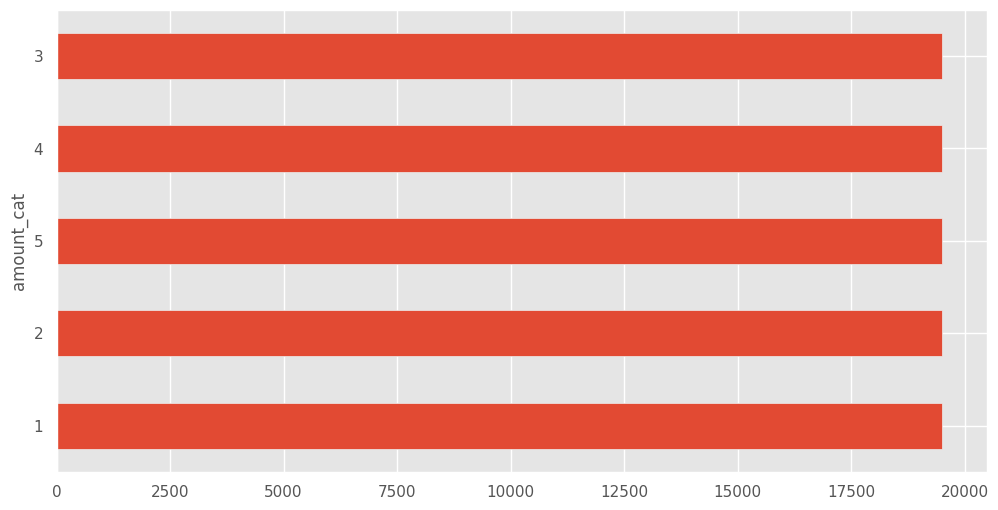

In [ ]:
# Amount bins
AMOUNT = True
if AMOUNT:
      final['amount_cat'] = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5])

      final['amount_cat'].value_counts().plot(kind='barh')
      plt.show()

      qcut_series, qcut_intervals = pd.qcut(final.Amount, q=5,labels=[1,2,3,4,5],retbins=True)

      qcut_series.value_counts()

In [ ]:
bins = [1,2,3,4,5]
for bin, interval in zip(bins, qcut_intervals):
    print(bin, round(interval,2))

1 0.01
2 21.8
3 84.9
4 215.07
5 549.45


In [ ]:
#final[['Amount', 'amount_cat']].head(100)

In [ ]:
final['amount_cat'] = final['amount_cat'].astype(str)

In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3360)
# new variables is  1


In [ ]:
# Foreign zipcode
zip_state = pd.read_csv('zip_code_database.csv')[['zip','state']]
zip_state.sample(5)
# Check if the zipcode of merchant is in the US
zip_state = pd.read_csv('zip_code_database.csv')['zip'].astype(float).astype(str).values
zip_state

array(['501.0', '544.0', '601.0', ..., '99928.0', '99929.0', '99950.0'],
      dtype=object)

In [ ]:
mapping = list(map(lambda x: x not in zip_state, final['Merch zip']))
final = pd.concat([final, pd.DataFrame({'foreign': mapping})], axis = 1)
final['foreign'] = final['foreign'].astype(int)

In [ ]:
final['foreign'].isnull().sum()

0

In [ ]:
print(final.shape)
print('# new variables is ',len(final.columns) - numstart)
numstart = len(final.columns)

(97496, 3361)
# new variables is  1


In [ ]:
final.fillna(0,inplace=True)

In [ ]:
final.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day,amount_cat,foreign
0,1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,0.005102,0.001111,0.000278,1.0,1.0,364,Friday,0,1,1
1,2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,...,0.005102,0.001111,0.000278,2.0,2.0,356,Friday,0,2,1
2,3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,3,1
3,4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,1,1
4,5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,...,0.005102,0.001111,0.000278,1.0,2.0,364,Friday,0,1,1


In [ ]:
final.shape

(97496, 3361)

In [ ]:
final.set_index('Recnum', inplace = True)

In [ ]:
final.columns.values.tolist()

['Cardnum',
 'Date',
 'Merchnum',
 'Merch description',
 'Merch state',
 'Merch zip',
 'Transtype',
 'Amount',
 'Fraud',
 'Dow',
 'Dow_Risk',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State',
 'Merch state_TE',
 'Merch zip_TE',
 'Dow_TE',
 'Cardnum_day_since',
 'Cardnum_count_0',
 'Cardnum_avg_0',
 'Cardnum_max_0',
 'Cardnum_med_0',
 'Cardnum_total_0',
 'Cardnum_actual/avg_0',
 'Cardnum_actual/max_0',
 'Cardnum_actual/med_0',
 'Cardnum_actual/toal_0',
 'Cardnum_count_1',
 'Cardnum_avg_1',
 'Cardnum_max_1',
 'Cardnum_med_1',
 'Cardnum_total_1',
 'Cardnum_actual/avg_1',
 'Cardnum_actual/max_1',
 'Cardnum_actual/med_1',
 'Cardnum_actual/toal_1',
 'Cardnum

### find the record number for the out-of-time validation data

You'll need these record numbers in your modeling code. Get them here sine I remove Date from the data file.

In [ ]:
temp = final[final['Date']>='2010-11-01']
ind1 = len(final)-len(temp)
print(final[ind1-3:ind1+3]['Date'])
# final['id1'] = final.index
# id1 = final.loc[indoot]['id1']
temp.reset_index(inplace=True)

Recnum
85261   2010-10-31
85262   2010-10-31
85263   2010-10-31
85264   2010-11-01
85265   2010-11-01
85266   2010-11-01
Name: Date, dtype: datetime64[ns]


In [ ]:
temp.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day,amount_cat,foreign
0,85264,5142150217,2010-11-01,680699669,GENERAL BINDING COR,IL,60062,P,182.00,0,...,0.005102,0.001111,0.000278,8.0,22.0,52,Monday,0,3,1
1,85265,5142259911,2010-11-01,615679280335,RICOH CORPORATION,NJ,07006,P,174.61,0,...,0.002551,0.000556,0.000139,9.0,22.0,58,Monday,0,3,1
2,85266,5142224817,2010-11-01,8000326863954,WRIGHT BROTHERS INC.,OH,45237,P,53.00,0,...,0.001701,0.000278,0.000025,9.0,22.0,58,Monday,0,2,1
3,85267,5142250016,2010-11-01,6029900666875,DALLAS LAMINATING & FI,TX,75207,P,25.00,0,...,0.005102,0.000556,0.000139,9.0,22.0,57,Monday,0,2,1
4,85268,5142236765,2010-11-01,89200775185,GRTR PHILA CABLE,PA,19147,P,97.17,0,...,0.005102,0.001111,0.000278,9.0,22.0,59,Monday,0,3,1


In [ ]:
indoot = temp.loc[0]['Recnum']
print(indoot)

85264


In [ ]:
temp = final[final['Date']>='2010-01-15']
ind2 = len(final)-len(temp)
print(final[ind2-3:ind2+3]['Date'])
# final['id1'] = final.index
# id1 = final.loc[indoot]['id1']
temp.reset_index(inplace=True)

Recnum
3463   2010-01-14
3464   2010-01-14
3465   2010-01-14
3466   2010-01-15
3467   2010-01-15
3468   2010-01-15
Name: Date, dtype: datetime64[ns]


In [ ]:
temp.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,...,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day,amount_cat,foreign
0,3466,5142289869,2010-01-15,602608969534,FISHER SCI ATL,GA,30091,P,333.47,0,...,0.001701,0.000370,0.000093,4.0,6.0,349,Friday,0,4,1
1,3467,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118,P,4.37,0,...,0.001701,0.000370,0.000093,4.0,6.0,348,Friday,0,1,1
2,3468,5142184598,2010-01-15,680655463,MC MASTER CARR SUPP,IL,60126,P,271.93,0,...,0.001701,0.000370,0.000093,4.0,6.0,350,Friday,0,4,1
3,3469,5142148452,2010-01-15,5509006296254,FEDEX SHP 01/10/10 AB#,TN,38118,P,3.62,0,...,0.002551,0.000556,0.000139,4.0,6.0,348,Friday,0,1,1
4,3470,5142195887,2010-01-15,4503082616100,OFFICE DEPOT #122,NC,27707,P,16.28,0,...,0.005102,0.001111,0.000278,4.0,6.0,320,Friday,0,1,1


In [ ]:
ind2w = temp.loc[0]['Recnum']
print(ind2w)

3466


In [ ]:
print('Recnum to exclude first 2 weeks:',ind2w)
print('Recnum to exclude oot for feature selection:', indoot)

Recnum to exclude first 2 weeks: 3466
Recnum to exclude oot for feature selection: 85264


In [ ]:
final.columns

Index(['Cardnum', 'Date', 'Merchnum', 'Merch description', 'Merch state',
       'Merch zip', 'Transtype', 'Amount', 'Fraud', 'Dow',
       ...
       'Card_Merchdesc_State_count_1_by_14_sq',
       'Card_Merchdesc_State_count_1_by_30_sq',
       'Card_Merchdesc_State_count_1_by_60_sq', 'transaction_count_7_days',
       'transaction_count_30_days', 'days_since_last_transaction',
       'day_of_week', 'hour_of_day', 'amount_cat', 'foreign'],
      dtype='object', length=3360)

In [ ]:
final.head()

,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,Dow,...,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day,amount_cat,foreign
Recnum,,,,,,,,,,,,,,,,,,,,,
1,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,...,0.005102,0.001111,0.000278,1.0,1.0,364,Friday,0,1,1
2,5142183973,2010-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,Friday,...,0.005102,0.001111,0.000278,2.0,2.0,356,Friday,0,2,1
3,5142131721,2010-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,Friday,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,3,1
4,5142148452,2010-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,Friday,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,1,1
5,5142190439,2010-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,Friday,...,0.005102,0.001111,0.000278,1.0,2.0,364,Friday,0,1,1


In [ ]:
entities

['Cardnum',
 'Merchnum',
 'card_merch',
 'card_zip',
 'card_state',
 'merch_zip',
 'merch_state',
 'state_des',
 'Card_Merchdesc',
 'Card_dow',
 'Merchnum_desc',
 'Merchnum_dow',
 'Merchdesc_dow',
 'Card_Merchnum_desc',
 'Card_Merchnum_Zip',
 'Card_Merchdesc_Zip',
 'Merchnum_desc_State',
 'Merchnum_desc_Zip',
 'merchnum_zip',
 'Merchdesc_State',
 'Merchdesc_Zip',
 'Card_Merchnum_State',
 'Card_Merchdesc_State']

In [ ]:
drop_columns = ['Date','Merch description','Merch state','Merch zip','Transtype','Dow']
final.drop(columns=entities,inplace=True)
final.drop(columns=drop_columns,inplace=True)
final.columns

Index(['Amount', 'Fraud', 'Dow_Risk', 'Merch state_TE', 'Merch zip_TE',
       'Dow_TE', 'Cardnum_day_since', 'Cardnum_count_0', 'Cardnum_avg_0',
       'Cardnum_max_0',
       ...
       'Card_Merchdesc_State_count_1_by_14_sq',
       'Card_Merchdesc_State_count_1_by_30_sq',
       'Card_Merchdesc_State_count_1_by_60_sq', 'transaction_count_7_days',
       'transaction_count_30_days', 'days_since_last_transaction',
       'day_of_week', 'hour_of_day', 'amount_cat', 'foreign'],
      dtype='object', length=3331)

In [ ]:
final.head()

,Amount,Fraud,Dow_Risk,Merch state_TE,Merch zip_TE,Dow_TE,Cardnum_day_since,Cardnum_count_0,Cardnum_avg_0,Cardnum_max_0,...,Card_Merchdesc_State_count_1_by_14_sq,Card_Merchdesc_State_count_1_by_30_sq,Card_Merchdesc_State_count_1_by_60_sq,transaction_count_7_days,transaction_count_30_days,days_since_last_transaction,day_of_week,hour_of_day,amount_cat,foreign
Recnum,,,,,,,,,,,,,,,,,,,,,
1,3.62,0,0.031756,0.017176,0.020604,0.031756,1461.0,1,3.62,3.62,...,0.005102,0.001111,0.000278,1.0,1.0,364,Friday,0,1,1
2,31.42,0,0.031756,0.015752,0.020604,0.031756,1461.0,1,31.42,31.42,...,0.005102,0.001111,0.000278,2.0,2.0,356,Friday,0,2,1
3,178.49,0,0.031756,0.028553,0.020604,0.031756,1461.0,1,178.49,178.49,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,3,1
4,3.62,0,0.031756,0.017176,0.020604,0.031756,1461.0,1,3.62,3.62,...,0.005102,0.001111,0.000278,2.0,2.0,362,Friday,0,1,1
5,3.62,0,0.031756,0.017176,0.020604,0.031756,0.0,2,3.62,3.62,...,0.005102,0.001111,0.000278,1.0,2.0,364,Friday,0,1,1


In [ ]:
%%time
# Remove any redundant columns.
# if the kernel dies in this cell it's likely due to memory problems.
# In that case, just write out the data file as is and you can read it in another notebook that only does deduping
print('before removing redundant columns:',final.shape)
final = final.T.drop_duplicates().T
print('after removing redundant columns:',final.shape)

before removing redundant columns: (97496, 3331)
after removing redundant columns: (97496, 2639)
CPU times: user 55.3 s, sys: 6.22 s, total: 1min 1s
Wall time: 60 s


In [ ]:
# check to see if all the entries are numeric rather than categorical.
# If False, then some are not numeric. We want True.
final_numeric = final.apply(pd.to_numeric, errors='coerce')
is_all_numeric = not final_numeric.isnull().values.any()
print(is_all_numeric)

False


In [ ]:
final.to_csv('candidate_variables.csv')

In [ ]:
print('Duration: ', dt.datetime.now() - start_time)

Duration:  0:21:11.286448


In [ ]:
%pwd

'/content'